# Imports

In [1]:
#!/usr/bin/env python3

import numpy as np
import sklearn as sk
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn import metrics
import gc
import time


from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

import seaborn as sns
from pylab import rcParams
import pickle
from sklearn import metrics
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from pyod.utils.example import visualize
import warnings
import matplotlib.font_manager
warnings.filterwarnings("ignore")

# Data Load

In [2]:
df = pd.read_csv('/Volumes/C/Thesis-2019/cluster-output/DG_out.csv', sep=',')
df.head()

,tx_hash,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,in_malicious,out_malicious,is_malicious,out_and_tx_malicious,all_malicious
0,0437cd7f8525ceed2324359c2d0ba26006d92d856a9c20...,0,1,0.0,50.0,50.0,0.0,50.0,0,0,0,0,0
1,f4184fc596403b9d638783cf57adfe4c75c605f6356fbc...,1,2,50.0,50.0,100.0,50.0,25.0,0,0,0,0,0
2,ea44e97271691990157559d0bdd9959e02790c34db6c00...,1,1,10.0,10.0,20.0,10.0,10.0,0,0,0,0,0
3,a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...,1,1,40.0,30.0,70.0,40.0,30.0,0,0,0,0,0
4,591e91f809d716912ca1d4a9295e70c3e78bab077683f7...,1,2,30.0,30.0,60.0,30.0,15.0,0,0,0,0,0


In [3]:
df.drop('tx_hash', axis=1, inplace=True)
df.drop('in_malicious', axis=1, inplace=True)
df.drop('out_malicious', axis=1, inplace=True)
df.drop('is_malicious', axis=1, inplace=True)
df.drop('all_malicious', axis=1, inplace=True)

# df.drop('in_btc', axis=1, inplace=True)
# df.drop('out_btc', axis=1, inplace=True)
# df.drop('total_btc', axis=1, inplace=True)
# df.drop('mean_in_btc', axis=1, inplace=True)
# df.drop('mean_out_btc', axis=1, inplace=True)


df.describe()

,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,out_and_tx_malicious
count,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07
mean,2.148699e+00,2.148699e+00,5.484150e+01,5.484150e+01,1.096830e+02,4.923980e+01,2.877087e+01,3.570468e-06
std,7.421447e+00,4.512048e+00,1.303303e+03,1.301473e+03,2.602527e+03,9.729210e+02,7.125567e+02,1.889565e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,2.000000e+00,1.000000e-01,9.950000e-02,2.058720e-01,6.400000e-02,5.025776e-02,0.000000e+00
50%,1.000000e+00,2.000000e+00,9.325000e-01,9.590000e-01,1.964759e+00,5.350261e-01,4.900000e-01,0.000000e+00
75%,2.000000e+00,2.000000e+00,8.591912e+00,9.063657e+00,1.840000e+01,5.614287e+00,4.519481e+00,0.000000e+00
max,1.932000e+03,1.322000e+03,5.500000e+05,5.000207e+05,1.050000e+06,4.992596e+05,5.000000e+05,1.000000e+00


In [4]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['out_and_tx_malicious'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['out_and_tx_malicious'].value_counts()[1]/len(df) * 100,5), '% of the dataset')

No Frauds 100.0 % of the dataset
Frauds 0.00036 % of the dataset


In [5]:
df['out_and_tx_malicious'].value_counts()

0    30248026
1         108
Name: out_and_tx_malicious, dtype: int64

# Scale transform

In [6]:
# Log scale to normalize the data
scaled_df = df.copy()

scaled_df['indegree'] = np.log1p(scaled_df['indegree'])
scaled_df['outdegree']= np.log1p(scaled_df['outdegree'])
scaled_df['in_btc'] = np.log1p(scaled_df['in_btc'])
scaled_df['out_btc']= np.log1p(scaled_df['out_btc'])
scaled_df['total_btc']= np.log1p(scaled_df['total_btc'])
scaled_df['mean_in_btc']= np.log1p(scaled_df['mean_in_btc'])
scaled_df['mean_out_btc']= np.log1p(scaled_df['mean_out_btc'])

# RobustScaler is less prone to outliers.
from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()

scaled_df['indegree'] = rob_scaler.fit_transform(scaled_df['indegree'].values.reshape(-1,1))
scaled_df['outdegree'] = rob_scaler.fit_transform(scaled_df['outdegree'].values.reshape(-1,1))
scaled_df['in_btc'] = rob_scaler.fit_transform(scaled_df['in_btc'].values.reshape(-1,1))
scaled_df['out_btc'] = rob_scaler.fit_transform(scaled_df['out_btc'].values.reshape(-1,1))
scaled_df['total_btc'] = rob_scaler.fit_transform(scaled_df['total_btc'].values.reshape(-1,1))
scaled_df['mean_in_btc'] = rob_scaler.fit_transform(scaled_df['mean_in_btc'].values.reshape(-1,1))
scaled_df['mean_out_btc'] = rob_scaler.fit_transform(scaled_df['mean_out_btc'].values.reshape(-1,1))

In [7]:
del df #free memory
gc.collect()

44

# Split

In [8]:
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(scaled_df.iloc[:,:-1], scaled_df['out_and_tx_malicious'], test_size = 0.20, random_state=10)

In [9]:
pd.value_counts(original_ytrain)

0    24198425
1          82
Name: out_and_tx_malicious, dtype: int64

In [10]:
pd.value_counts(original_ytest)

0    6049601
1         26
Name: out_and_tx_malicious, dtype: int64

In [11]:
del scaled_df #free memory
gc.collect()

55

# Get Training Sample

In [12]:
from sklearn.utils import shuffle

original_train_df = pd.concat([original_Xtrain, original_ytrain], axis=1)
original_train_normal_df = original_train_df[original_train_df.out_and_tx_malicious == 0]
original_train_fraud_df = original_train_df[original_train_df.out_and_tx_malicious == 1]

def get_training_sample(n):
    normal_sample = original_train_normal_df.sample(n)
    final_sample = pd.concat([normal_sample, original_train_fraud_df])
    final_sample = shuffle(final_sample)

    return final_sample.iloc[:,:-1].values, final_sample.iloc[:,-1].values

# Get Test Sample

In [13]:
original_test_df = pd.concat([original_Xtest, original_ytest], axis=1)
original_test_normal_df = original_test_df[original_test_df.out_and_tx_malicious == 0]
original_test_fraud_df = original_test_df[original_test_df.out_and_tx_malicious == 1]

def get_test_sample(n):
    normal_sample = original_test_normal_df.sample(n)
    final_sample = pd.concat([normal_sample, original_test_fraud_df])
    final_sample = shuffle(final_sample)
    return final_sample.iloc[:,:-1].values, final_sample.iloc[:,-1].values

# Oversample Training Data

In [14]:
from imblearn.over_sampling import SMOTE

def oversample_minority_class(X, y, fraction):
    SM = SMOTE(fraction, n_jobs=-1)
    return SM.fit_resample(X, y)

# Evaluation Metrics

In [15]:
def evaluate(actual, predicted, probability, time_complexity):
    eval_metric = {}
    eval_metric['time'] = time_complexity
    eval_metric['conf_matrix'] = confusion_matrix(actual, predicted)
    
    eval_metric['balanced_accuracy'] = round(balanced_accuracy_score(actual, predicted),7)
    eval_metric['accuracy'] = round(accuracy_score(actual, predicted),7)
    
    eval_metric['macro_precision'] = round(precision_score(actual, predicted, average="macro"),7)
    eval_metric['macro_recall'] = round(recall_score(actual,predicted, average="macro"),7)
    eval_metric['macro_f1'] = round(f1_score(actual,predicted, average="macro"),7)
    eval_metric['macro_roc'] = round(roc_auc_score(actual, probability, average="macro"),7)

    
    eval_metric['precision'] = round(precision_score(actual, predicted),7)
    eval_metric['recall'] = round(recall_score(actual,predicted),7)
    eval_metric['f1'] = round(f1_score(actual,predicted),7)
    eval_metric['roc'] = round(roc_auc_score(actual, probability),7)

    false_pos_rate, true_pos_rate, thresholds = roc_curve(actual, probability)
    eval_metric['false_pos_rate'] = false_pos_rate
    eval_metric['true_pos_rate'] = true_pos_rate
    eval_metric['thresholds'] = thresholds
    
    precision_rt, recall_rt, threshold_rt = precision_recall_curve(actual, probability)
    eval_metric['precision_rt'] = precision_rt
    eval_metric['recall_rt'] = recall_rt
    eval_metric['threshold_rt'] = threshold_rt
    return eval_metric

# Save Model

In [16]:
model_path = './Models/HBOS/'

def save_model(model, path):
    pickle.dump(model, open(path, 'wb'))

# Fit Model

In [21]:
from pyod.models.hbos import HBOS

iterations = 20
random_state = 42
training_sample_size = int(len(original_ytrain) / 10)
oversampling_fraction = 0.249
outliers_fraction = oversampling_fraction

print('Training Parameters:\n====================\n')
print('Iterations: '+ str(iterations))
print('Training Sample Size: '+ str(training_sample_size))
print('Oversampling Fraction: '+ str(oversampling_fraction))
print('Outliers Fraction: '+ str(outliers_fraction))


best: {'alpha': 0.7140354276549626, 'n_bins': 7.4609367241884765, 'outliers_fraction': 0.24962378421955286, 'tol': 0.3798459940762142}


def fit_model(X_train):
    clf = HBOS(n_bins=8, alpha=0.714, tol=0.379, contamination=outliers_fraction)
    clf.fit(X_train)
    return clf

Training Parameters:

Iterations: 20
Training Sample Size: 2419850
Oversampling Fraction: 0.249
Outliers Fraction: 0.249


# Iterative Modeling

In [22]:
training_evaluations = {}
test_evaluations = {}
model = {}

for i in range(0, iterations):
    sample_Xtrain, sample_ytrain = get_training_sample(training_sample_size)
    X_train, y_train = oversample_minority_class(sample_Xtrain, sample_ytrain, oversampling_fraction)
    print("Iteration "+ str(i+1)+ " in progress...")

    #Modeling
    start = time.time()
    clf = fit_model(X_train)
    end = time.time()
    save_model(clf, model_path+'i='+str(i+1)+'.h5')
    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    training_time = round(end - start, 4)
    model[i+1] = clf
    training_evaluations[i+1] = evaluate(y_train, y_train_pred, y_train_scores, training_time)
    
    print("Iteration "+ str(i+1)+ " Trained")

    test_start = time.time()
    y_test_pred = clf.predict(original_Xtest)
    y_test_scores = clf.decision_function(original_Xtest)
    test_end = time.time()
    testing_time = round(test_end - test_start, 4)
    test_evaluations[i+1] = evaluate(original_ytest, y_test_pred, y_test_scores, testing_time)

    print("Iteration: (" + str((i+1)) + "/" + str(iterations) + ")    Training Time: "+str(training_time)+" seconds     Testing Time: "+ str(testing_time)+ " seconds")

print("Iterative Modeling Completed!")

Iteration 1 in progress...
Iteration 1 Trained
Iteration: (1/20)    Training Time: 1.3421 seconds     Testing Time: 4.4509 seconds
Iteration 2 in progress...
Iteration 2 Trained
Iteration: (2/20)    Training Time: 1.1706 seconds     Testing Time: 2.5366 seconds
Iteration 3 in progress...
Iteration 3 Trained
Iteration: (3/20)    Training Time: 1.4542 seconds     Testing Time: 2.4839 seconds
Iteration 4 in progress...
Iteration 4 Trained
Iteration: (4/20)    Training Time: 1.3222 seconds     Testing Time: 2.492 seconds
Iteration 5 in progress...
Iteration 5 Trained
Iteration: (5/20)    Training Time: 1.1901 seconds     Testing Time: 2.7831 seconds
Iteration 6 in progress...
Iteration 6 Trained
Iteration: (6/20)    Training Time: 1.1679 seconds     Testing Time: 2.5219 seconds
Iteration 7 in progress...
Iteration 7 Trained
Iteration: (7/20)    Training Time: 1.1771 seconds     Testing Time: 2.5446 seconds
Iteration 8 in progress...
Iteration 8 Trained
Iteration: (8/20)    Training Time: 1

# Tabular Evaluation

In [23]:
training_eval_df = pd.DataFrame(columns=['Iteration','Accuracy','Balanced-Accuracy','Macro-Precision','Macro-Recall','Macro-F1','Macro-ROC', 'Precision', 'Recall', 'F1', 'ROC', 'Time'])
test_eval_df = pd.DataFrame(columns=['Iteration','Accuracy','Balanced-Accuracy','Macro-Precision','Macro-Recall','Macro-F1','Macro-ROC', 'Precision', 'Recall', 'F1', 'ROC', 'Time'])
for it in list(training_evaluations.keys()):
    training_eval_df = training_eval_df.append({'Iteration' : str(it),
                             'Accuracy' : training_evaluations[it]['accuracy'],
                             'Balanced-Accuracy' : training_evaluations[it]['balanced_accuracy'],
                             'Macro-Precision' : training_evaluations[it]['macro_precision'],
                             'Macro-Recall' : training_evaluations[it]['macro_recall'],
                             'Macro-F1' : training_evaluations[it]['macro_f1'],
                             'Macro-ROC' : training_evaluations[it]['macro_roc'],
                             'Precision' : training_evaluations[it]['precision'],
                             'Recall' : training_evaluations[it]['recall'],
                             'F1' : training_evaluations[it]['f1'],
                             'ROC' : training_evaluations[it]['roc'],
                             'Time' : training_evaluations[it]['time']                                              
                            }, ignore_index=True)
    
for it in list(test_evaluations.keys()):
    test_eval_df = test_eval_df.append({'Iteration' : str(it),
                             'Accuracy' : test_evaluations[it]['accuracy'],
                             'Balanced-Accuracy' : test_evaluations[it]['balanced_accuracy'],
                             'Macro-Precision' : test_evaluations[it]['macro_precision'],
                             'Macro-Recall' : test_evaluations[it]['macro_recall'],
                             'Macro-F1' : test_evaluations[it]['macro_f1'],
                             'Macro-ROC' : test_evaluations[it]['macro_roc'],
                             'Precision' : test_evaluations[it]['precision'],
                             'Recall' : test_evaluations[it]['recall'],
                             'F1' : test_evaluations[it]['f1'],
                             'ROC' : test_evaluations[it]['roc'],
                             'Time' : test_evaluations[it]['time']                                              
                            }, ignore_index=True)

In [24]:
training_eval_df.sort_values('Macro-F1', ascending=False)

,Iteration,Accuracy,Balanced-Accuracy,Macro-Precision,Macro-Recall,Macro-F1,Macro-ROC,Precision,Recall,F1,ROC,Time
14,15,0.857460,0.794962,0.775530,0.794962,0.784471,0.880219,0.629901,0.691021,0.659047,0.880219,1.1888
12,13,0.857261,0.794398,0.775246,0.794398,0.784068,0.880203,0.629603,0.689851,0.658351,0.880203,1.1697
11,12,0.856922,0.793780,0.774752,0.793780,0.783520,0.878854,0.628883,0.688767,0.657464,0.878854,1.1653
0,1,0.857022,0.793258,0.774919,0.793258,0.783397,0.879194,0.629540,0.687212,0.657113,0.879194,1.3421
4,5,0.856360,0.792043,0.773952,0.792043,0.782321,0.877926,0.628130,0.685076,0.655368,0.877926,1.1901
2,3,0.856291,0.792042,0.773846,0.792042,0.782259,0.877456,0.627903,0.685189,0.655296,0.877456,1.4542
13,14,0.847649,0.799336,0.762194,0.799336,0.777689,0.878736,0.598070,0.718987,0.652978,0.878736,1.1607
1,2,0.847627,0.798635,0.762111,0.798635,0.777398,0.877766,0.598315,0.717155,0.652367,0.877766,1.1706
3,4,0.845629,0.801872,0.759972,0.801872,0.776940,0.877600,0.591544,0.729101,0.653158,0.877600,1.3222
7,8,0.847228,0.798301,0.761586,0.798301,0.776929,0.877681,0.597354,0.716931,0.651702,0.877681,1.2399


In [25]:
training_eval_df.sort_values('ROC', ascending=False)

,Iteration,Accuracy,Balanced-Accuracy,Macro-Precision,Macro-Recall,Macro-F1,Macro-ROC,Precision,Recall,F1,ROC,Time
14,15,0.857460,0.794962,0.775530,0.794962,0.784471,0.880219,0.629901,0.691021,0.659047,0.880219,1.1888
12,13,0.857261,0.794398,0.775246,0.794398,0.784068,0.880203,0.629603,0.689851,0.658351,0.880203,1.1697
0,1,0.857022,0.793258,0.774919,0.793258,0.783397,0.879194,0.629540,0.687212,0.657113,0.879194,1.3421
16,17,0.843229,0.800405,0.757000,0.800405,0.774350,0.878977,0.585810,0.729186,0.649682,0.878977,1.1610
15,16,0.845240,0.799600,0.759276,0.799600,0.775741,0.878875,0.591409,0.723696,0.650899,0.878875,1.1703
11,12,0.856922,0.793780,0.774752,0.793780,0.783520,0.878854,0.628883,0.688767,0.657464,0.878854,1.1653
13,14,0.847649,0.799336,0.762194,0.799336,0.777689,0.878736,0.598070,0.718987,0.652978,0.878736,1.1607
5,6,0.845130,0.800333,0.759220,0.800333,0.775930,0.878612,0.590828,0.725830,0.651408,0.878612,1.1679
8,9,0.844630,0.799311,0.758519,0.799311,0.775114,0.878310,0.589899,0.723940,0.650082,0.878310,1.2939
19,20,0.844928,0.799925,0.758937,0.799925,0.775602,0.878035,0.590449,0.725081,0.650876,0.878035,1.1645


In [26]:
test_eval_df.sort_values('Macro-F1', ascending=False)

,Iteration,Accuracy,Balanced-Accuracy,Macro-Precision,Macro-Recall,Macro-F1,Macro-ROC,Precision,Recall,F1,ROC,Time
4,5,0.899034,0.814902,0.500015,0.814902,0.473448,0.913777,0.000031,0.730769,0.000062,0.913777,2.7831
2,3,0.899026,0.814898,0.500015,0.814898,0.473445,0.913763,0.000031,0.730769,0.000062,0.913763,2.4839
0,1,0.899022,0.814896,0.500015,0.814896,0.473444,0.913857,0.000031,0.730769,0.000062,0.913857,4.4509
14,15,0.898753,0.814762,0.500015,0.814762,0.473370,0.914020,0.000031,0.730769,0.000062,0.914020,2.6611
11,12,0.898675,0.814723,0.500015,0.814723,0.473348,0.913601,0.000031,0.730769,0.000062,0.913601,2.5596
12,13,0.898660,0.814715,0.500015,0.814715,0.473343,0.918190,0.000031,0.730769,0.000062,0.918190,2.5640
1,2,0.880192,0.843942,0.500014,0.843942,0.468168,0.912984,0.000029,0.807692,0.000058,0.912984,2.5366
7,8,0.879901,0.843797,0.500014,0.843797,0.468086,0.913079,0.000029,0.807692,0.000058,0.913079,2.5057
13,14,0.879889,0.843791,0.500014,0.843791,0.468083,0.913121,0.000029,0.807692,0.000058,0.913121,3.0518
15,16,0.875420,0.803095,0.500012,0.803095,0.466811,0.910772,0.000025,0.730769,0.000050,0.910772,2.5402


In [27]:
test_eval_df.sort_values('ROC', ascending=False)

,Iteration,Accuracy,Balanced-Accuracy,Macro-Precision,Macro-Recall,Macro-F1,Macro-ROC,Precision,Recall,F1,ROC,Time
12,13,0.898660,0.814715,0.500015,0.814715,0.473343,0.918190,0.000031,0.730769,0.000062,0.918190,2.5640
14,15,0.898753,0.814762,0.500015,0.814762,0.473370,0.914020,0.000031,0.730769,0.000062,0.914020,2.6611
0,1,0.899022,0.814896,0.500015,0.814896,0.473444,0.913857,0.000031,0.730769,0.000062,0.913857,4.4509
4,5,0.899034,0.814902,0.500015,0.814902,0.473448,0.913777,0.000031,0.730769,0.000062,0.913777,2.7831
2,3,0.899026,0.814898,0.500015,0.814898,0.473445,0.913763,0.000031,0.730769,0.000062,0.913763,2.4839
11,12,0.898675,0.814723,0.500015,0.814723,0.473348,0.913601,0.000031,0.730769,0.000062,0.913601,2.5596
16,17,0.871294,0.839493,0.500013,0.839493,0.465637,0.913317,0.000027,0.807692,0.000054,0.913317,2.5208
13,14,0.879889,0.843791,0.500014,0.843791,0.468083,0.913121,0.000029,0.807692,0.000058,0.913121,3.0518
7,8,0.879901,0.843797,0.500014,0.843797,0.468086,0.913079,0.000029,0.807692,0.000058,0.913079,2.5057
1,2,0.880192,0.843942,0.500014,0.843942,0.468168,0.912984,0.000029,0.807692,0.000058,0.912984,2.5366


# Visualization

### Metrics

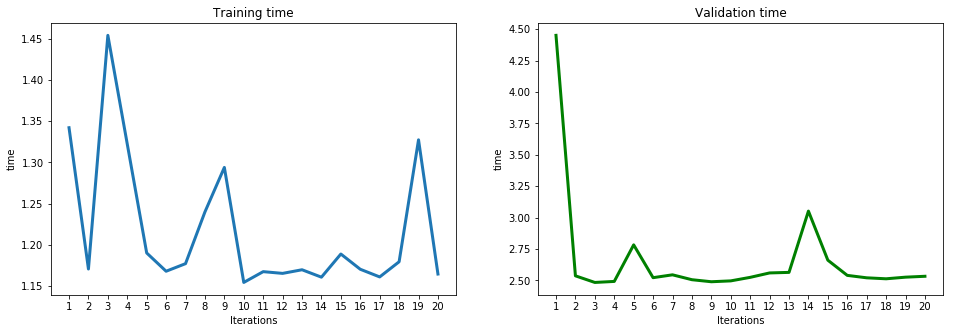

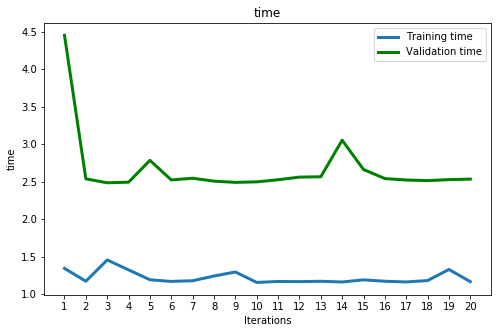

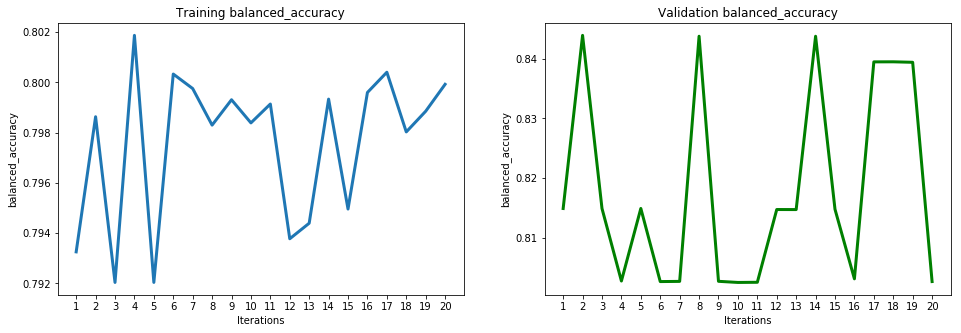

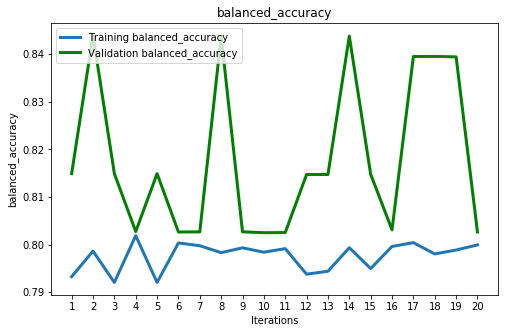

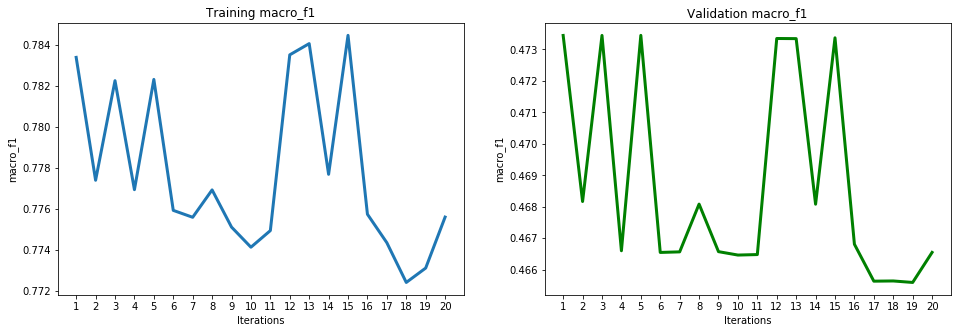

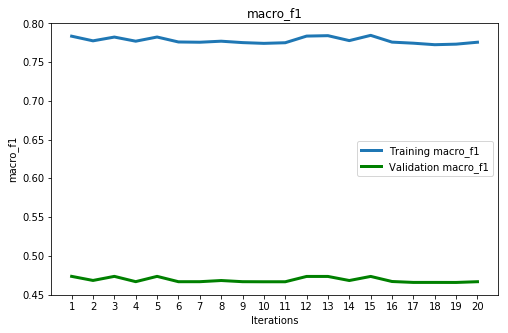

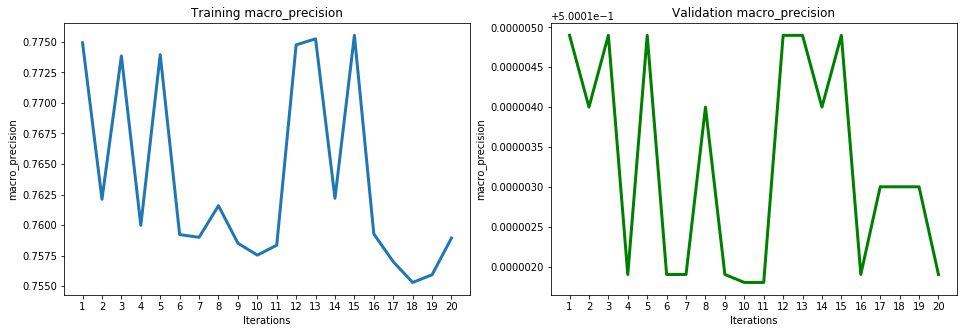

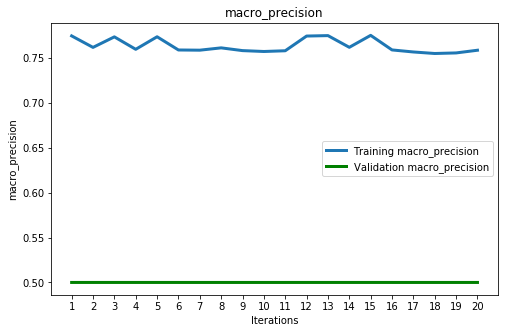

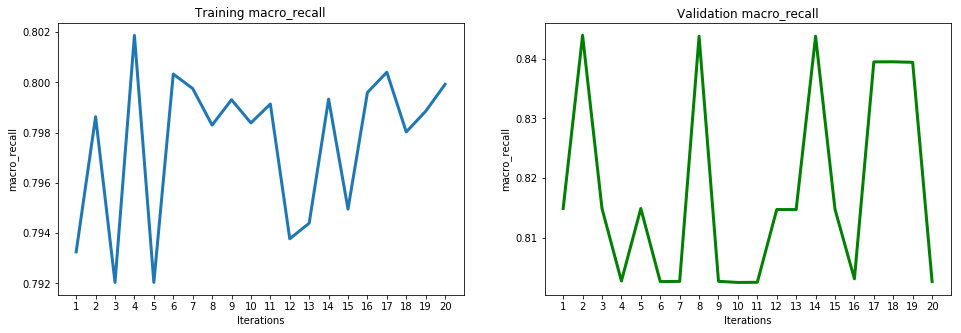

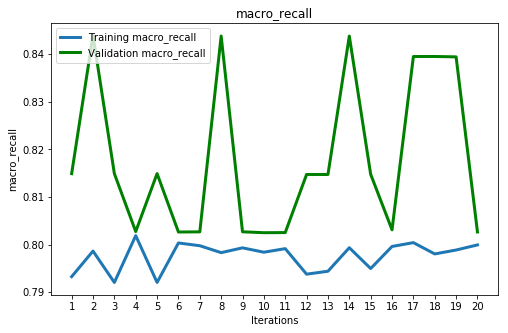

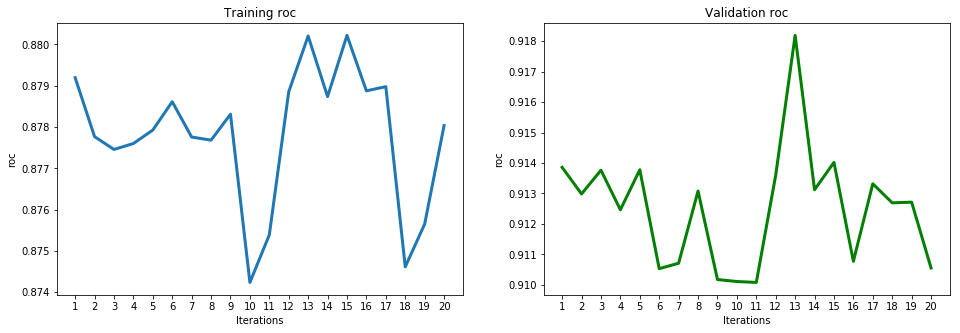

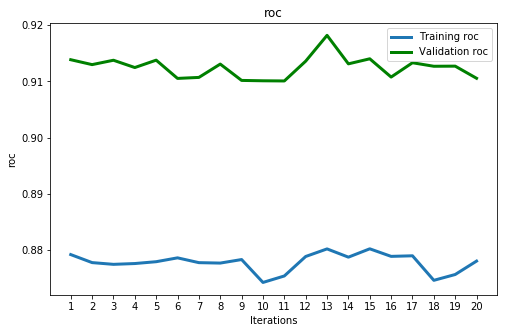

In [28]:
#metrics = ['time', 'accuracy', 'balanced_accuracy', 'f1', 'macro_f1', 'precision', 'macro_precision', 'recall', 'macro_recall', 'roc', 'macro_roc']
metrics = ['time', 'balanced_accuracy', 'macro_f1', 'macro_precision', 'macro_recall', 'roc']
for metric in metrics:    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    iterations = list(training_evaluations.keys())
    result1 = [training_evaluations[i][metric] for i in list(training_evaluations.keys())]
    ax1.plot(iterations, result1, label="Training "+metric, linewidth=3)
    ax1.set_xticks(iterations)
    ax1.set_title('Training '+metric)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel(metric)

    result2 = [test_evaluations[i][metric] for i in list(test_evaluations.keys())]
    ax2.plot(iterations, result2, label="Validation "+metric, linewidth=3, color='g')
    ax2.set_xticks(iterations)
    ax2.set_title('Validation '+metric)
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel(metric)

    plt.figure(1)
    iterations = list(training_evaluations.keys())
    result1 = [training_evaluations[i][metric] for i in list(training_evaluations.keys())]
    result2 = [test_evaluations[i][metric] for i in list(test_evaluations.keys())]
    plt.figure(figsize=(8, 5))
    plt.xticks(iterations)
    plt.plot(iterations, result1, label="Training "+metric, linewidth=3)
    plt.plot(iterations, result2, label="Validation "+metric, linewidth=3, color='g')
    plt.legend()
    plt.title(metric)
    plt.xlabel('Iterations')
    plt.ylabel(metric)
    plt.show()

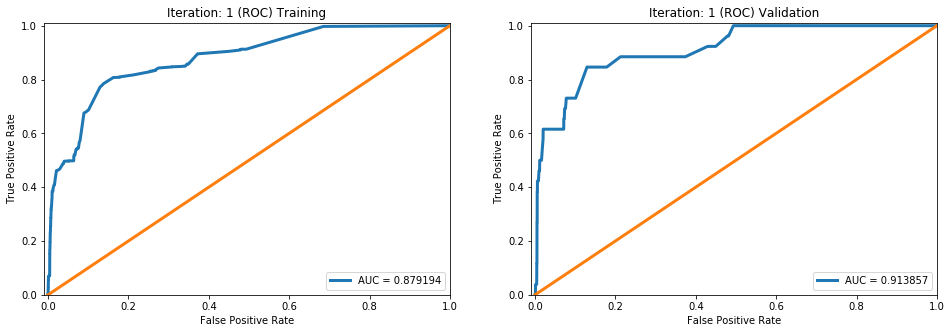

<Figure size 432x288 with 0 Axes>

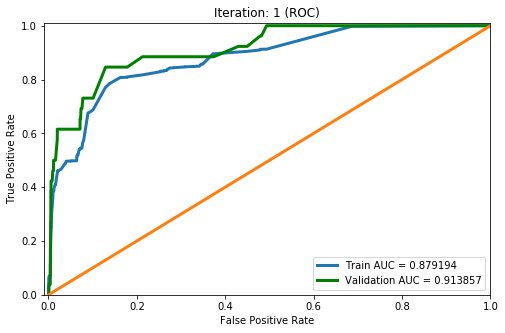

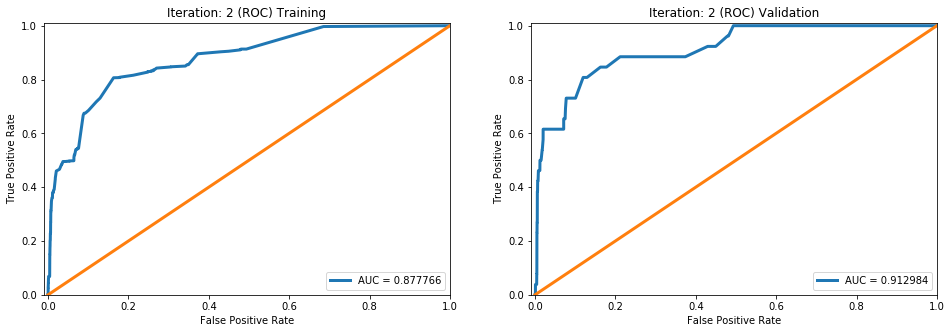

<Figure size 432x288 with 0 Axes>

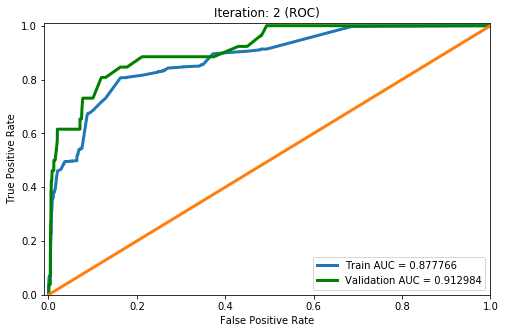

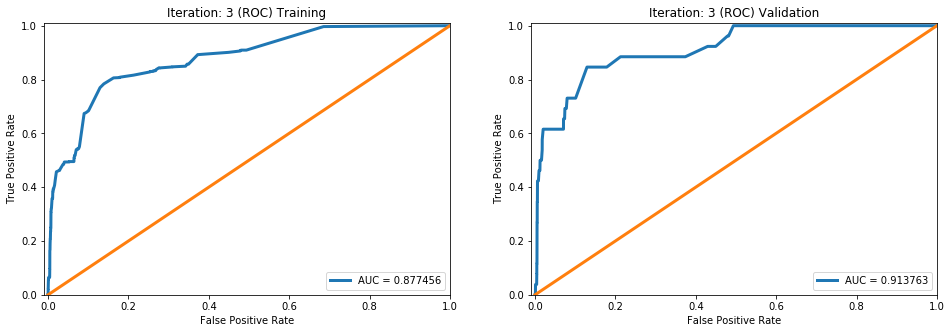

<Figure size 432x288 with 0 Axes>

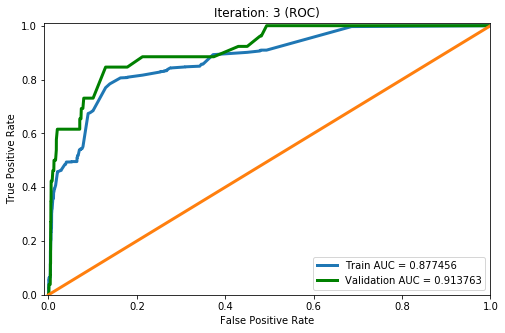

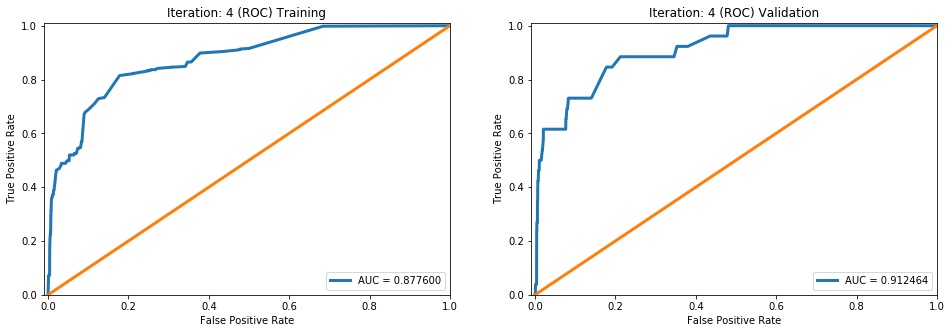

<Figure size 432x288 with 0 Axes>

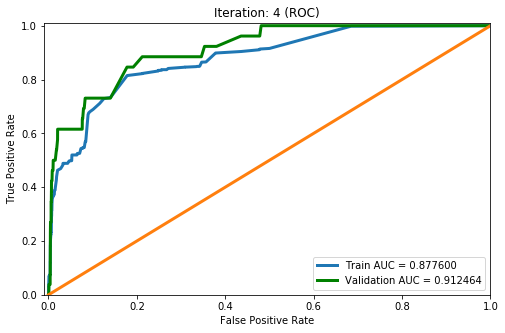

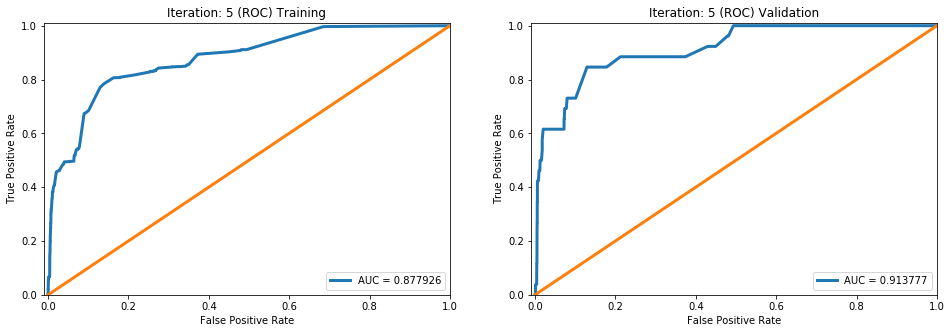

<Figure size 432x288 with 0 Axes>

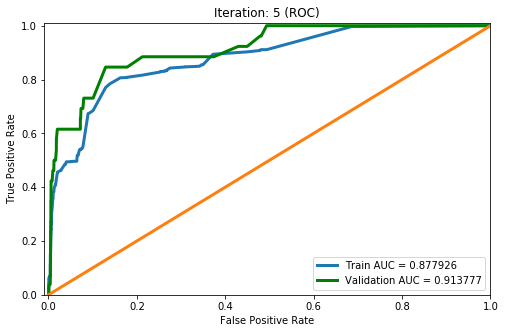

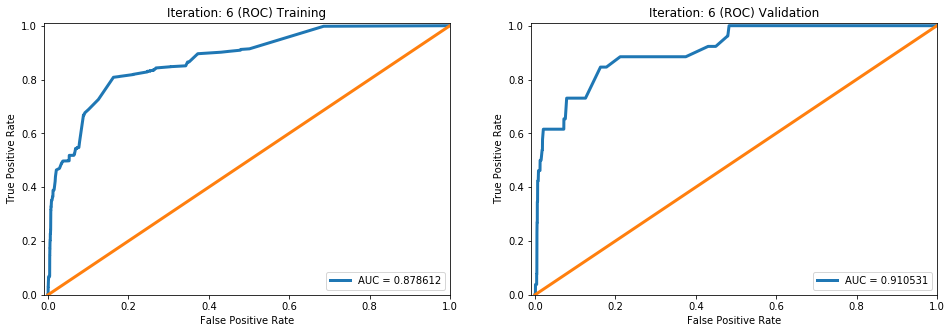

<Figure size 432x288 with 0 Axes>

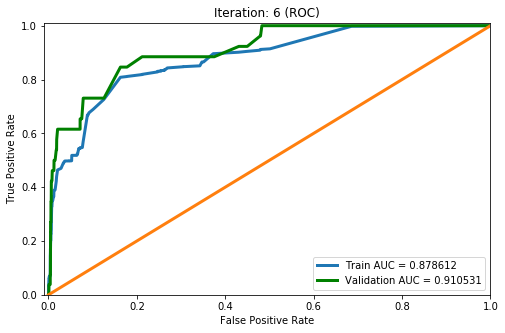

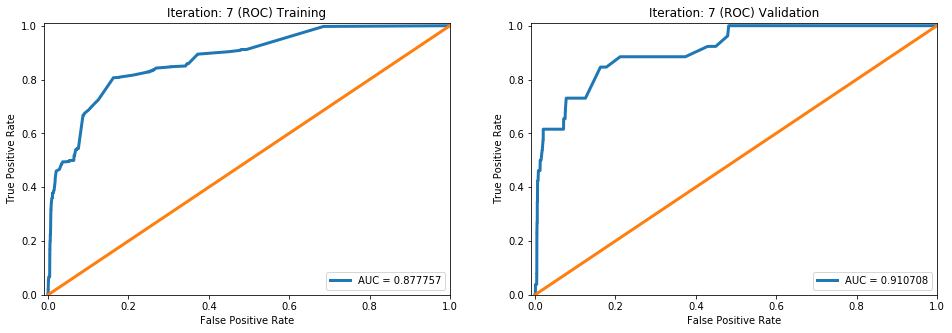

<Figure size 432x288 with 0 Axes>

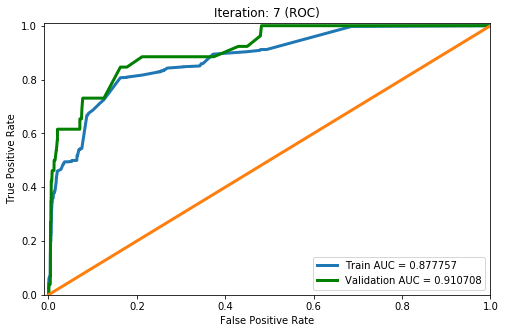

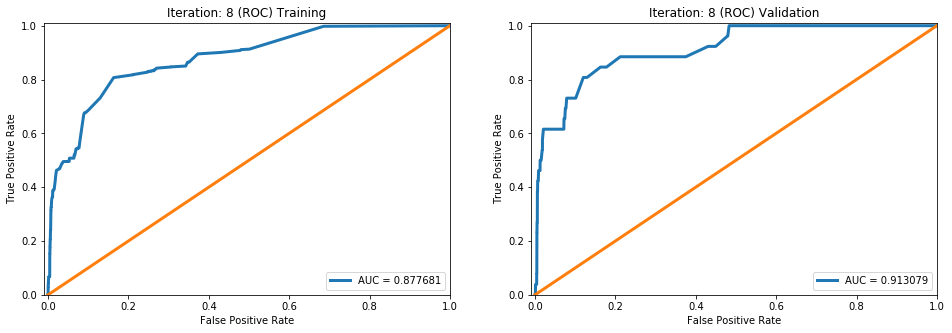

<Figure size 432x288 with 0 Axes>

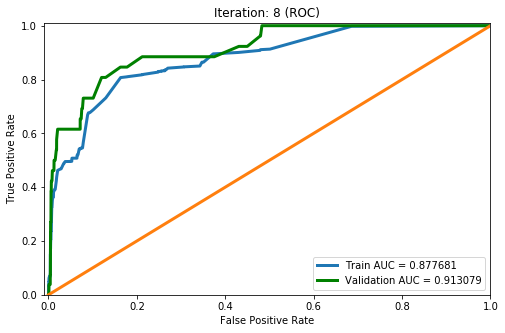

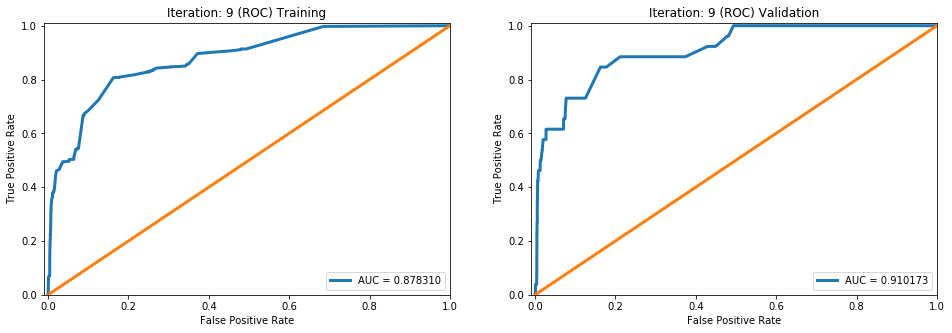

<Figure size 432x288 with 0 Axes>

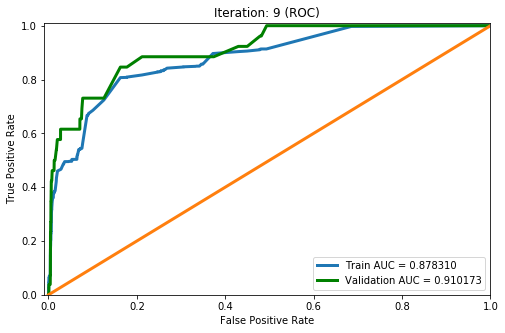

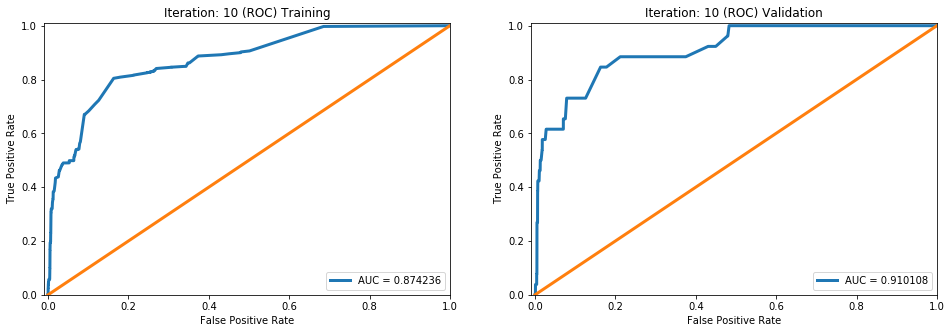

<Figure size 432x288 with 0 Axes>

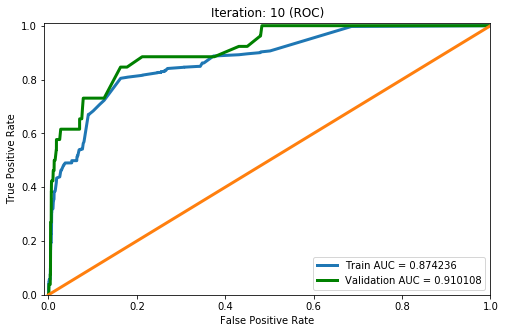

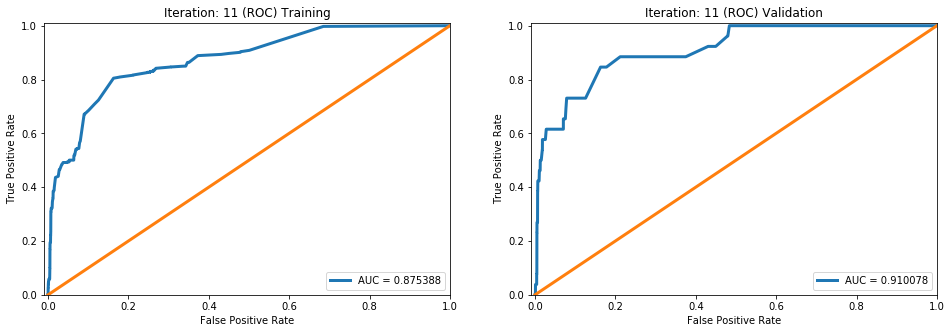

<Figure size 432x288 with 0 Axes>

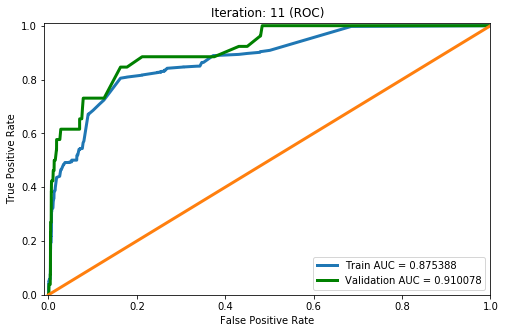

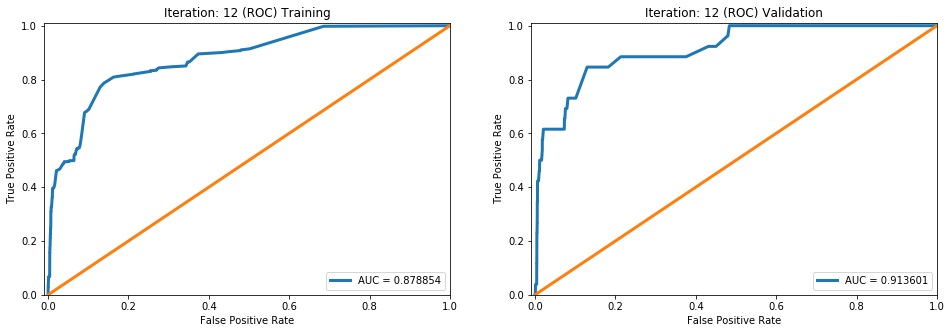

<Figure size 432x288 with 0 Axes>

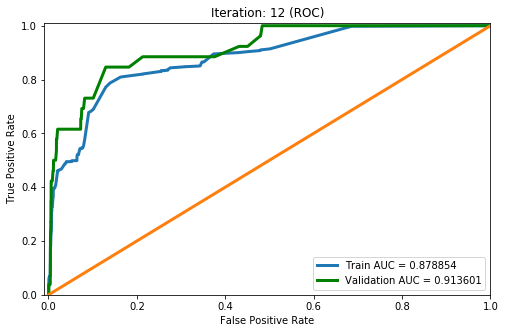

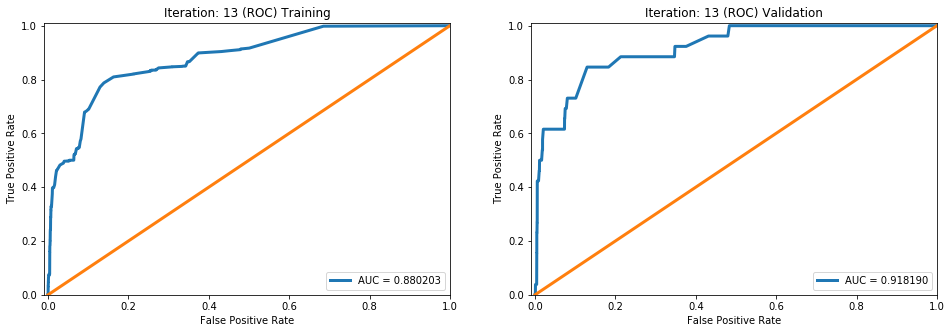

<Figure size 432x288 with 0 Axes>

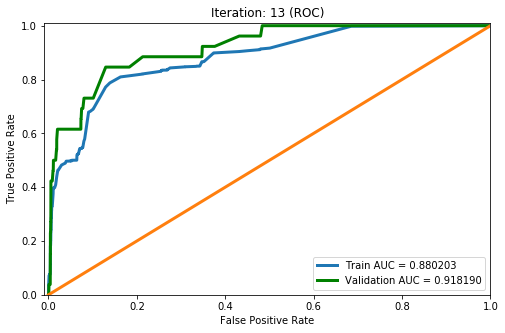

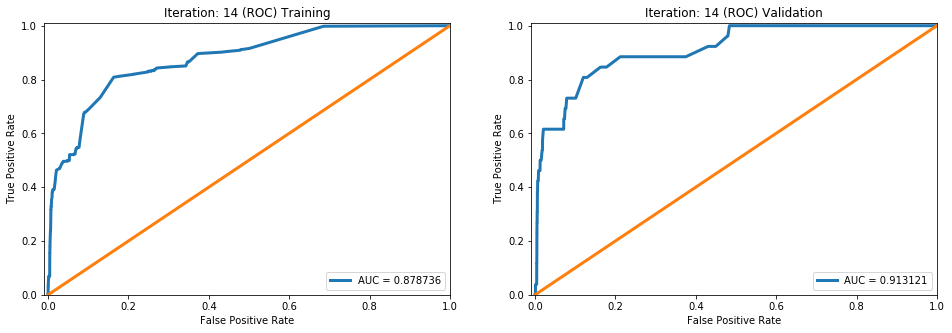

<Figure size 432x288 with 0 Axes>

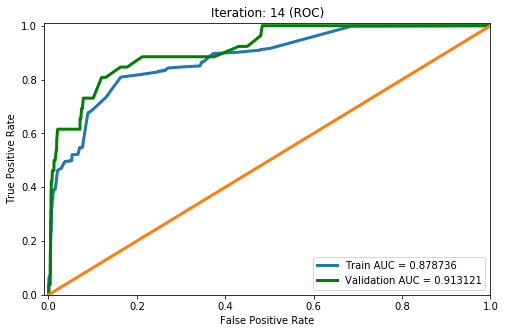

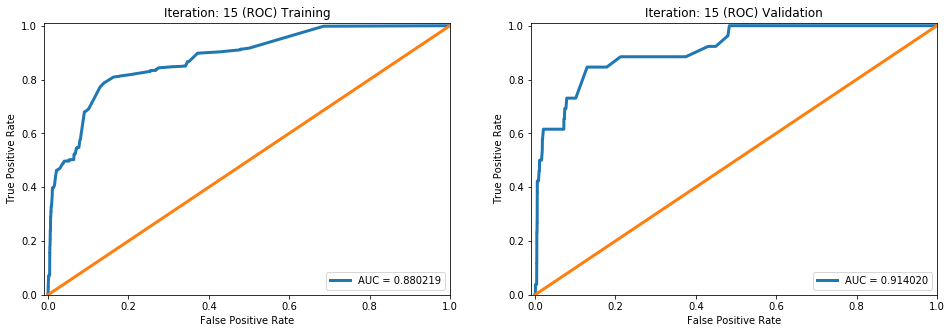

<Figure size 432x288 with 0 Axes>

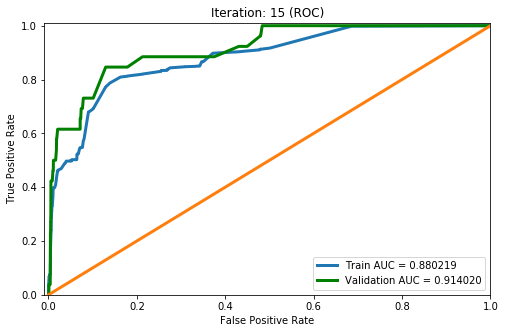

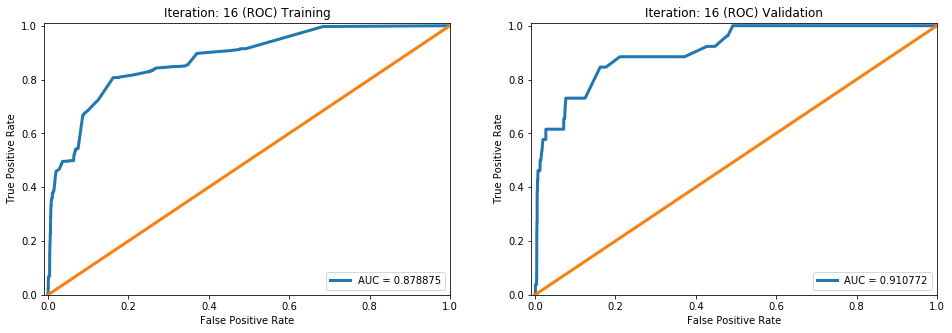

<Figure size 432x288 with 0 Axes>

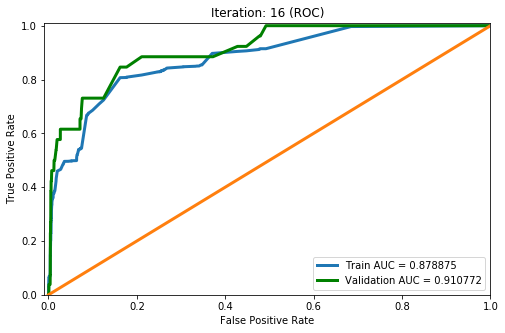

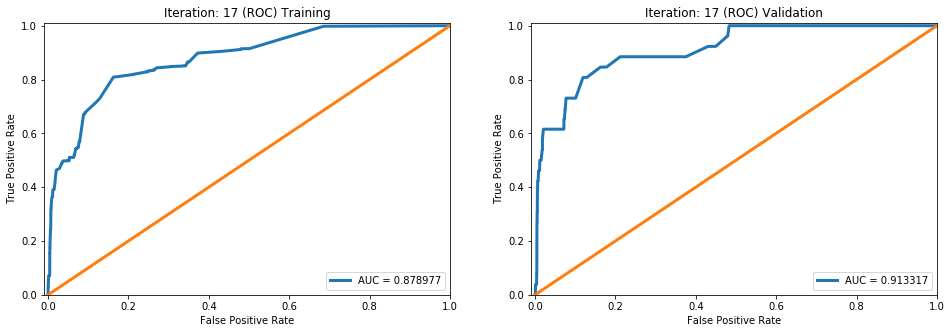

<Figure size 432x288 with 0 Axes>

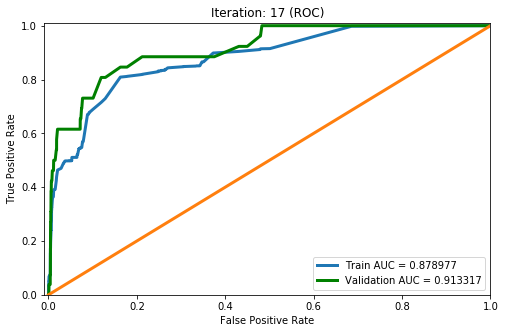

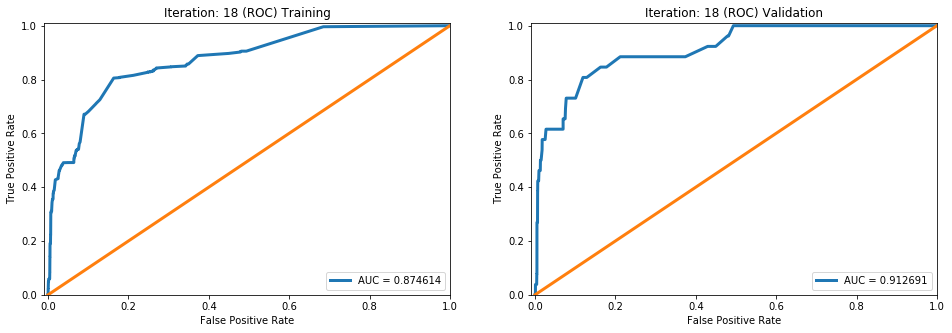

<Figure size 432x288 with 0 Axes>

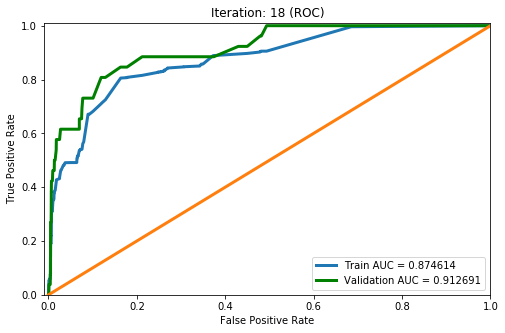

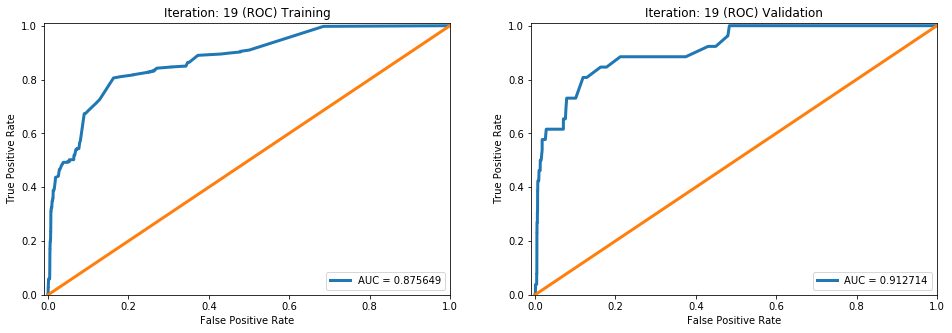

<Figure size 432x288 with 0 Axes>

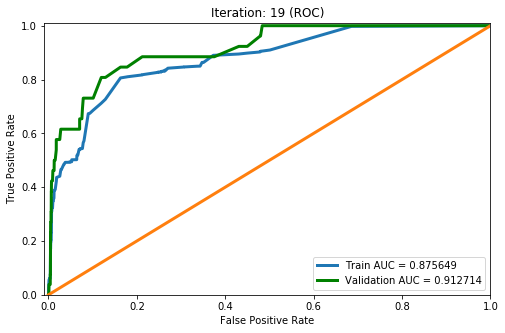

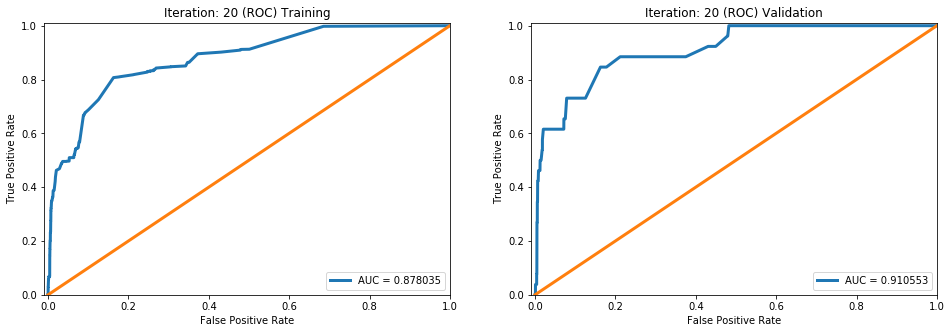

<Figure size 432x288 with 0 Axes>

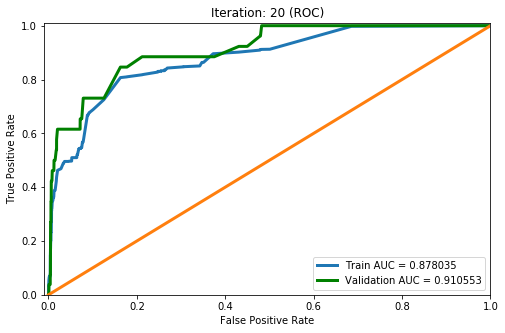

In [29]:
for it in iterations:
    false_pos_rate = training_evaluations[it]['false_pos_rate']
    true_pos_rate = training_evaluations[it]['true_pos_rate']
    roc_auc = auc(false_pos_rate, true_pos_rate)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    ax1.plot(false_pos_rate, true_pos_rate, linewidth=3, label='AUC = %f'% roc_auc)
    ax1.plot([0,1],[0,1], linewidth=3)

    ax1.set_xlim([-0.01, 1])
    ax1.set_ylim([0, 1.01])
    ax1.legend(loc='lower right')
    ax1.set_title('Iteration: '+ str(it) +' (ROC) Training')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    
    test_false_pos_rate = test_evaluations[it]['false_pos_rate']
    test_true_pos_rate = test_evaluations[it]['true_pos_rate']
    test_roc_auc = auc(test_false_pos_rate, test_true_pos_rate)
    
    ax2.plot(test_false_pos_rate, test_true_pos_rate, linewidth=3, label='AUC = %f'% test_roc_auc)
    ax2.plot([0,1],[0,1], linewidth=3)

    ax2.set_xlim([-0.01, 1])
    ax2.set_ylim([0, 1.01])
    ax2.legend(loc='lower right')
    ax2.set_title('Iteration: '+ str(it) +' (ROC) Validation')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_xlabel('False Positive Rate')

    plt.figure(2)
    false_pos_rate = training_evaluations[it]['false_pos_rate']
    true_pos_rate = training_evaluations[it]['true_pos_rate']
    roc_auc = auc(false_pos_rate, true_pos_rate)

    test_false_pos_rate = test_evaluations[it]['false_pos_rate']
    test_true_pos_rate = test_evaluations[it]['true_pos_rate']
    test_roc_auc = auc(test_false_pos_rate, test_true_pos_rate)

    plt.figure(figsize=(8, 5))
    plt.plot(false_pos_rate, true_pos_rate, linewidth=3, label='Train AUC = %f'% roc_auc)
    plt.plot(test_false_pos_rate, test_true_pos_rate, linewidth=3, label='Validation AUC = %f'% test_roc_auc, color='g')
    plt.plot([0,1],[0,1], linewidth=3)
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])

    plt.legend(loc='lower right')
    plt.title('Iteration: '+ str(it) +' (ROC)')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

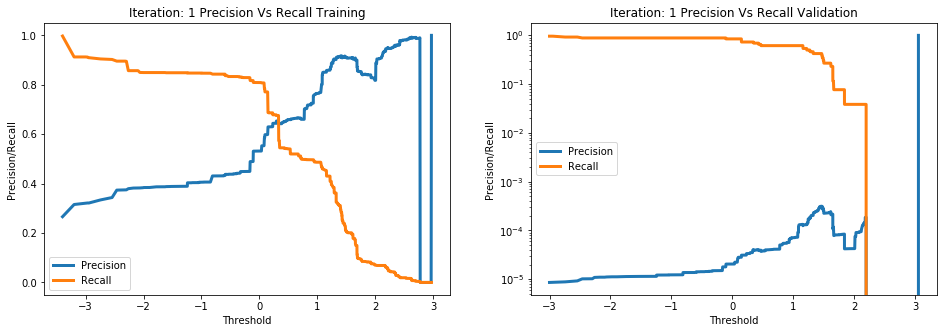

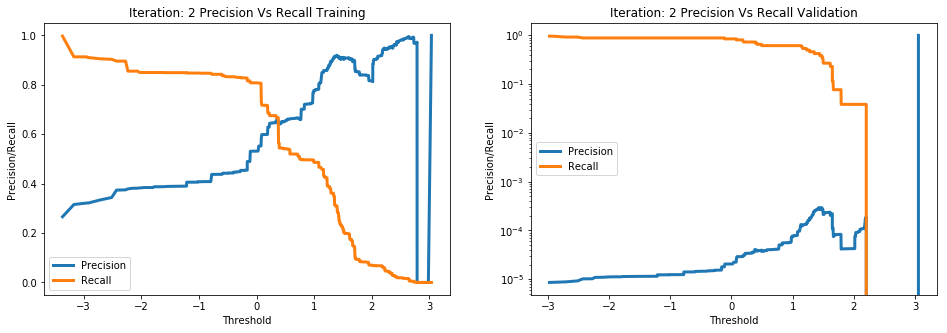

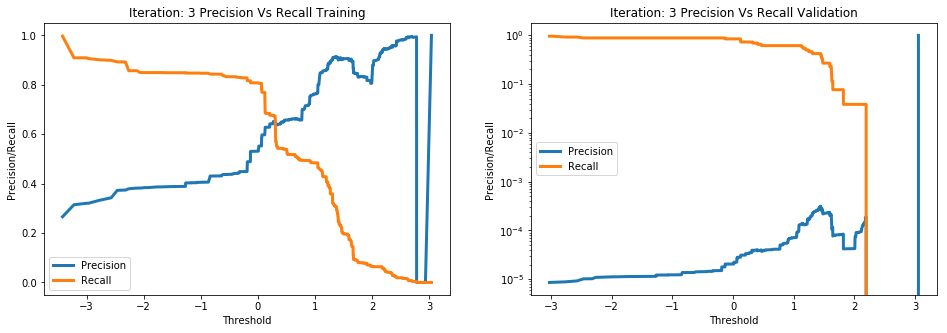

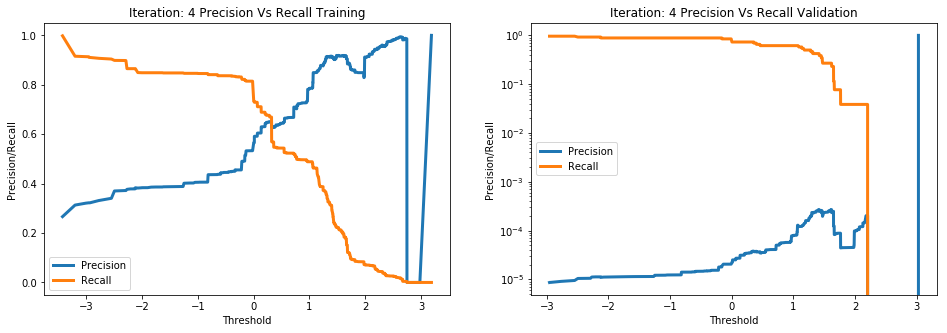

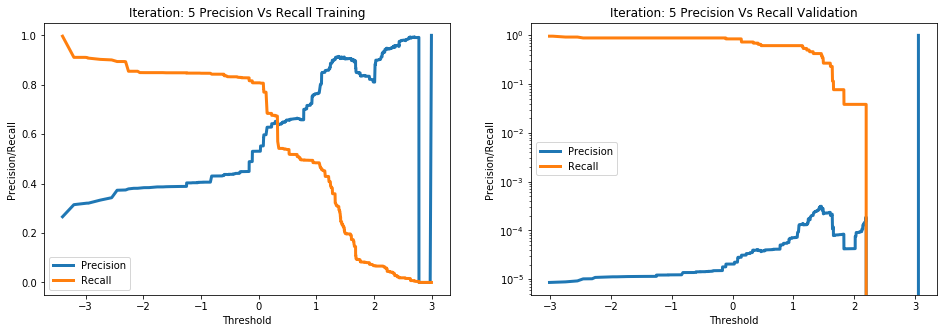

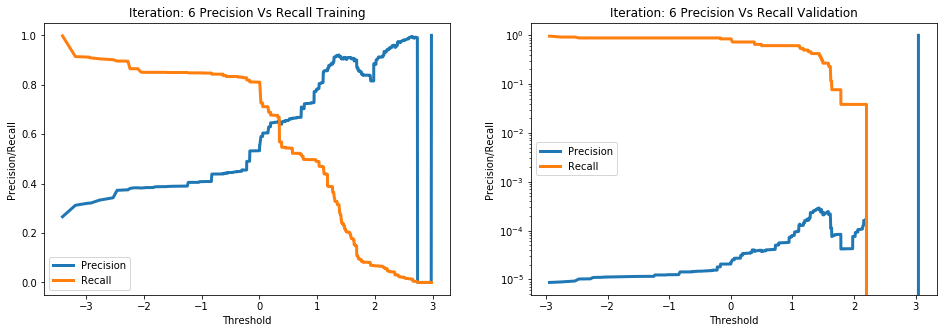

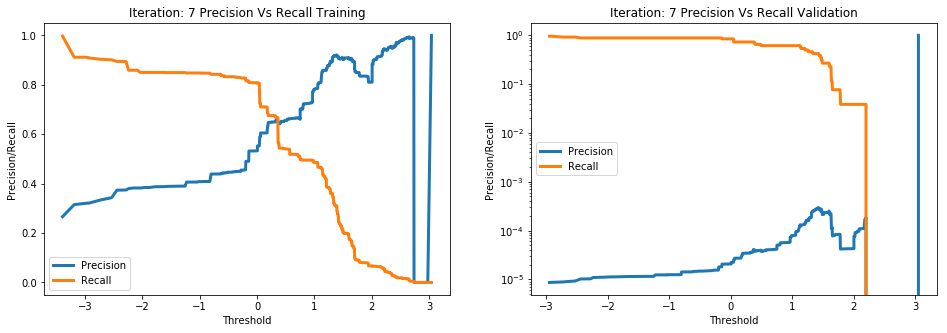

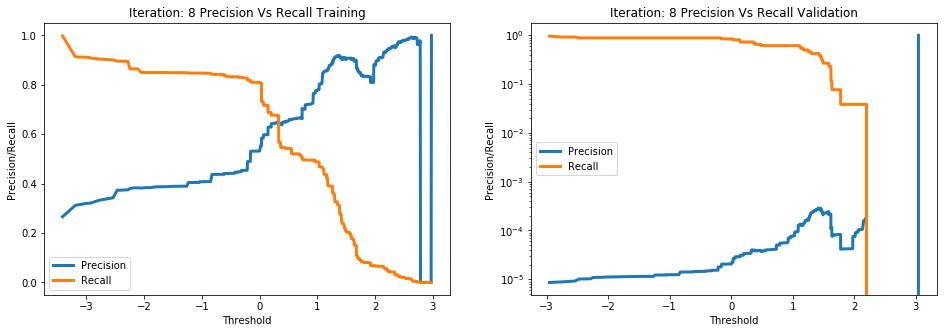

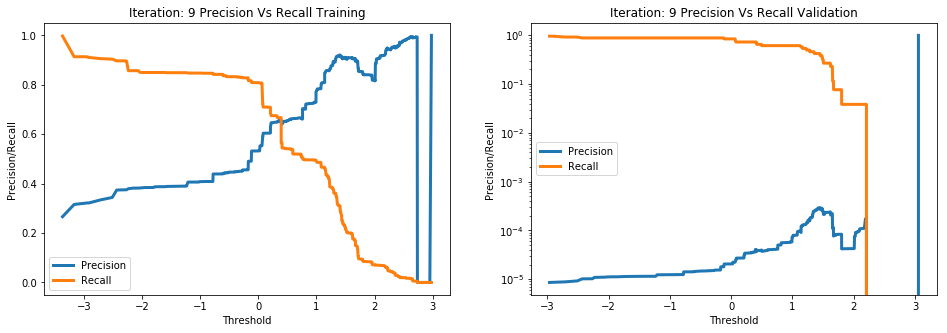

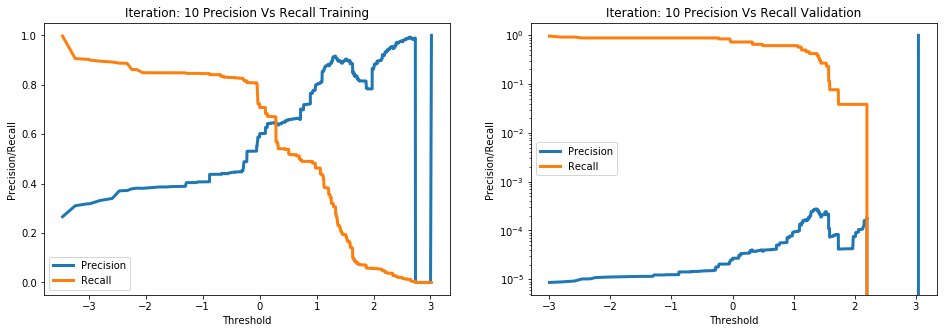

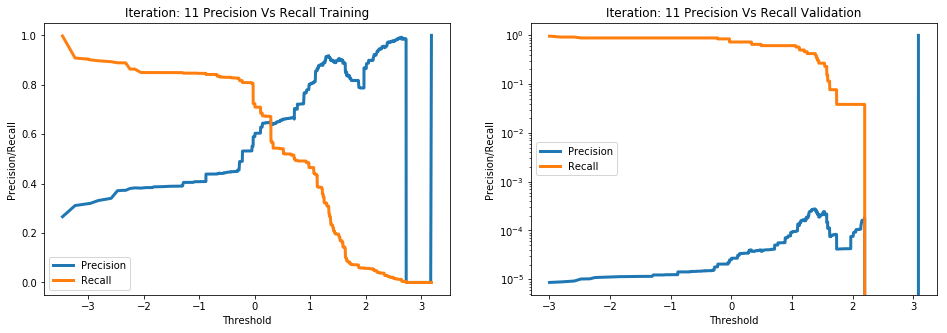

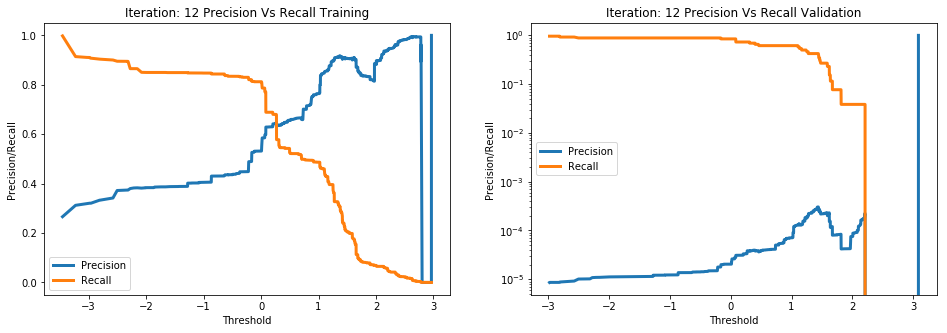

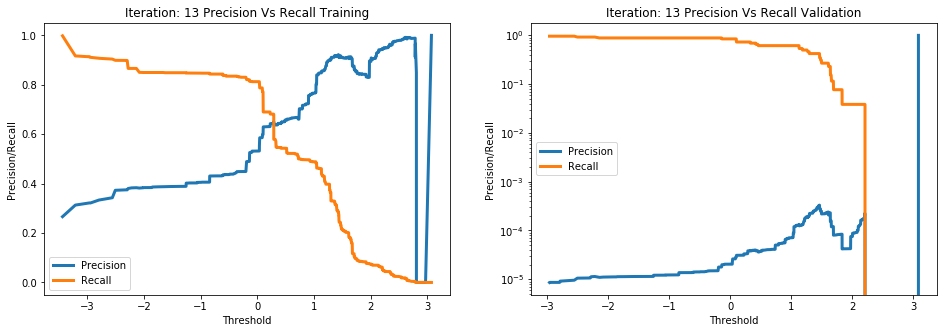

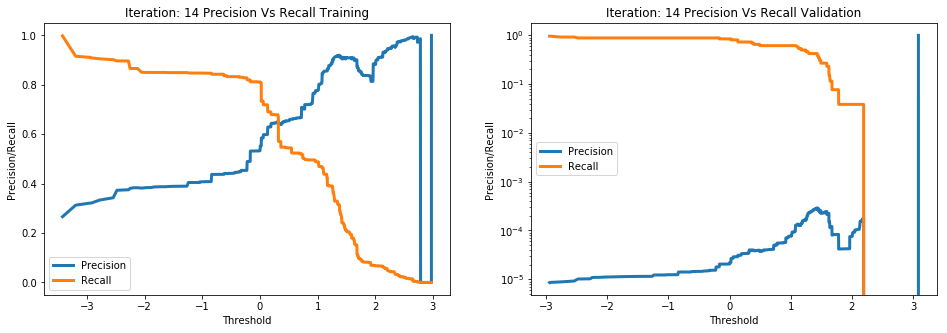

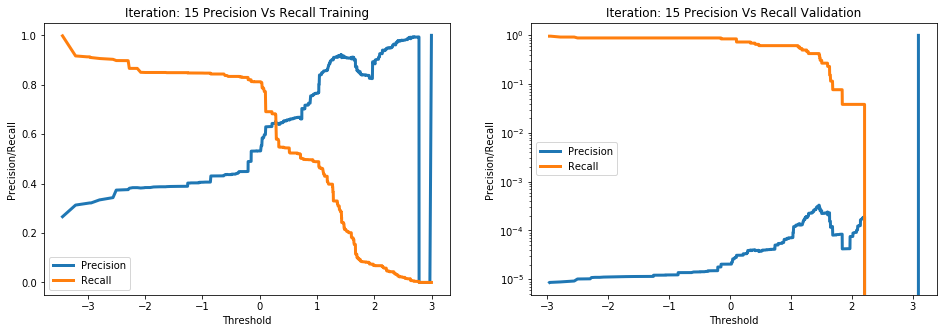

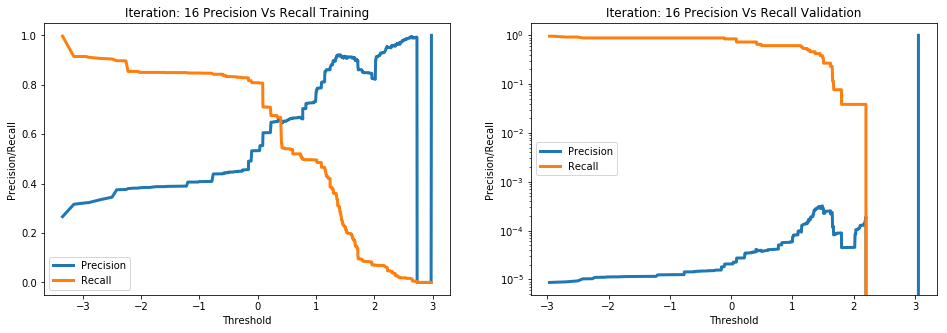

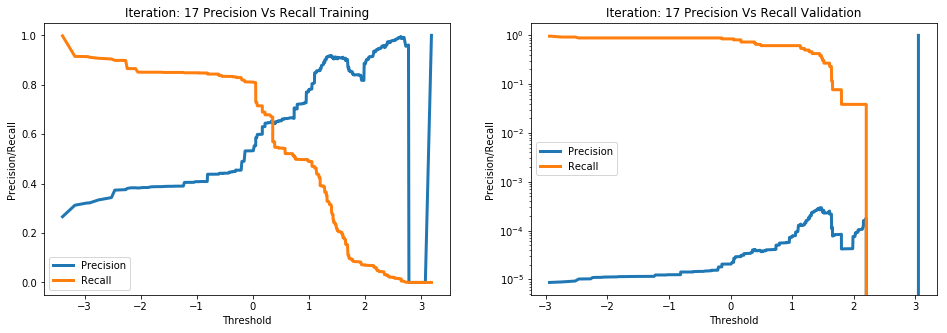

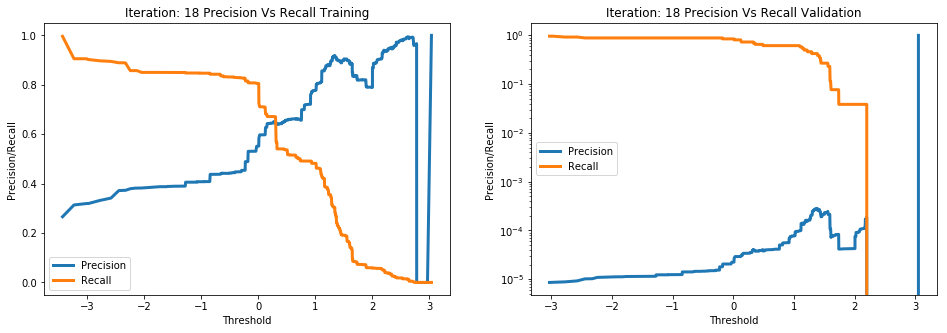

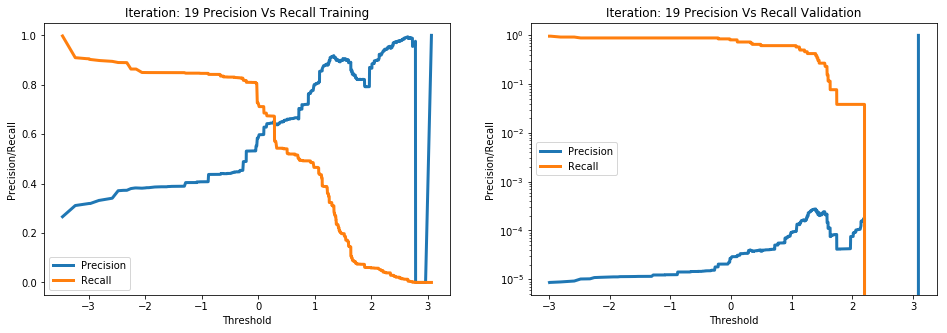

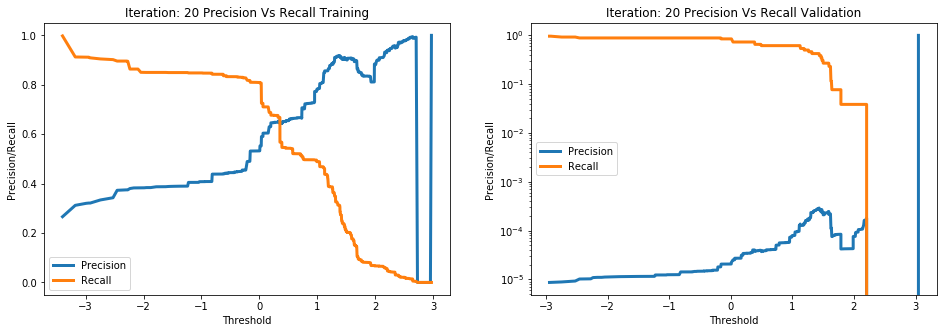

In [30]:
for it in iterations:
    precision_rt = training_evaluations[it]['precision_rt']
    recall_rt = training_evaluations[it]['recall_rt']
    threshold_rate = training_evaluations[it]['threshold_rt']
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    ax1.plot(threshold_rate, precision_rt[1:], label="Precision",linewidth=3)
    ax1.plot(threshold_rate, recall_rt[1:], label="Recall",linewidth=3)
#     ax1.set_yscale('log')
    ax1.legend()
    ax1.set_title('Iteration: '+ str(it) +' Precision Vs Recall Training')
    ax1.set_ylabel('Precision/Recall')
    ax1.set_xlabel('Threshold')
    
    
    precision_rt = test_evaluations[it]['precision_rt']
    recall_rt = test_evaluations[it]['recall_rt']
    threshold_rate = test_evaluations[it]['threshold_rt']
    ax2.plot(threshold_rate, precision_rt[1:], label="Precision",linewidth=3)
    ax2.plot(threshold_rate, recall_rt[1:], label="Recall",linewidth=3)
    ax2.legend()
    ax2.set_yscale('log')
    ax2.set_title('Iteration: '+ str(it) +' Precision Vs Recall Validation')
    ax2.set_ylabel('Precision/Recall')
    ax2.set_xlabel('Threshold')

# Confusion Matrix

In [31]:
def conf_matrix_percent(conf_matrix_train, conf_matrix_test, iteration):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    LABELS = ["Normal", "Fraud"]
    #Confusion Matrix Visual)
    conf_matrix_train = conf_matrix_train.astype('float') / (conf_matrix_train.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_train, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".0%", annot_kws={"size": 12}, ax=ax1)
    ax1.set_title("Training Iteration: "+str(iteration)+" Confusion matrix")
    ax1.set_ylabel('True class')
    ax1.set_xlabel('Predicted class')
    
    conf_matrix_test = conf_matrix_test.astype('float') / (conf_matrix_test.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_test, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".0%", annot_kws={"size": 12}, ax=ax2)
    ax2.set_title("Test Iteration: "+str(iteration)+" Confusion matrix")
    ax2.set_ylabel('True class')
    ax2.set_xlabel('Predicted class')

In [32]:
def conf_matrix_normal(conf_matrix_train, conf_matrix_test, iteration):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    LABELS = ["Normal", "Fraud"]
    #Confusion Matrix Visual)
#     conf_matrix_train = conf_matrix_train.astype('float') / (conf_matrix_train.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_train, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", ax=ax1);
    ax1.set_title("Training Iteration: "+str(iteration)+" Confusion matrix")
    ax1.set_ylabel('True class')
    ax1.set_xlabel('Predicted class')
    
#     conf_matrix_test = conf_matrix_test.astype('float') / (conf_matrix_test.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_test, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", ax=ax2);
    ax2.set_title("Test Iteration: "+str(iteration)+" Confusion matrix")
    ax2.set_ylabel('True class')
    ax2.set_xlabel('Predicted class')

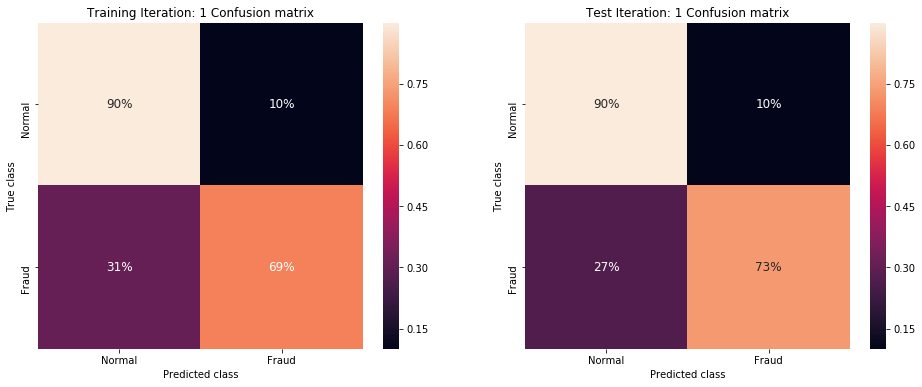

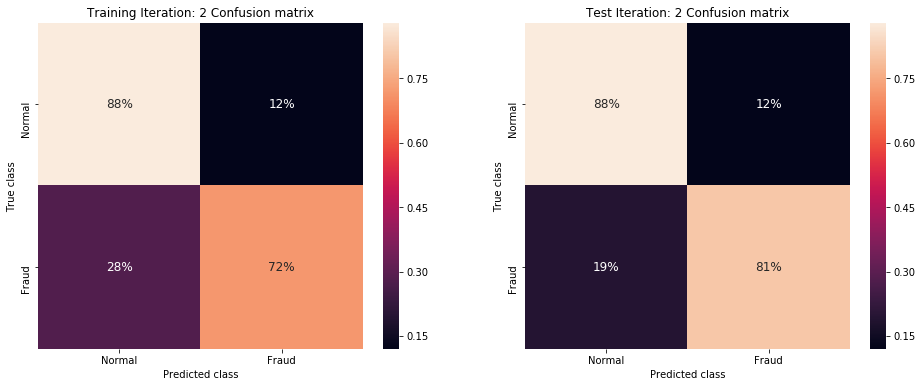

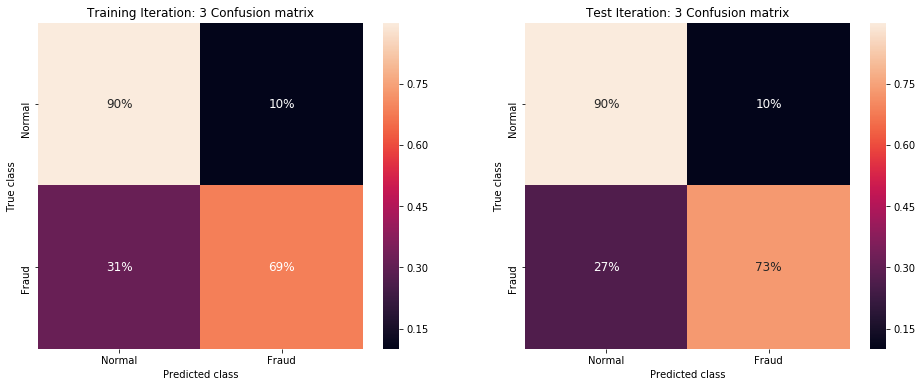

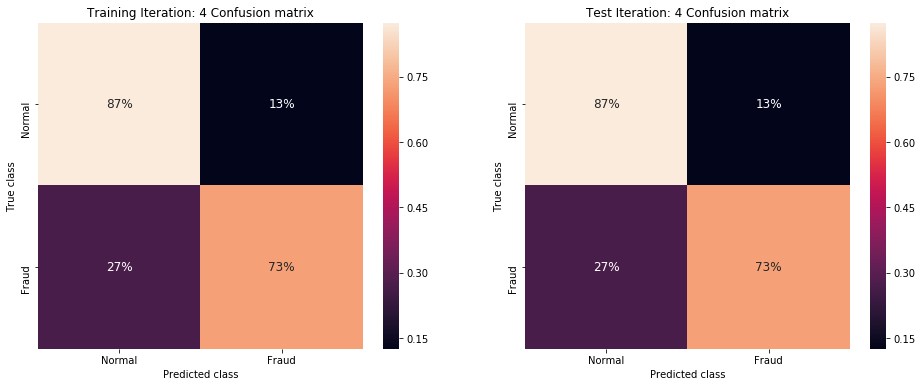

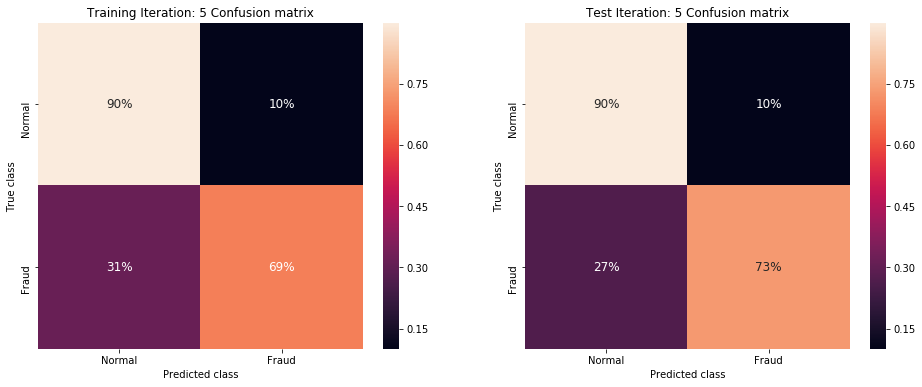

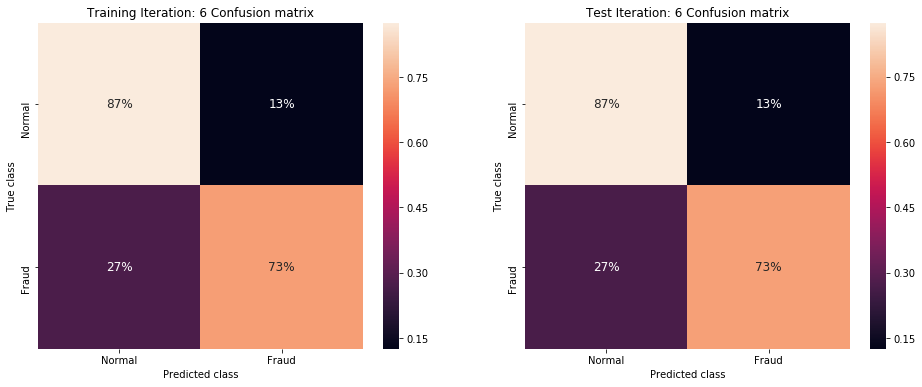

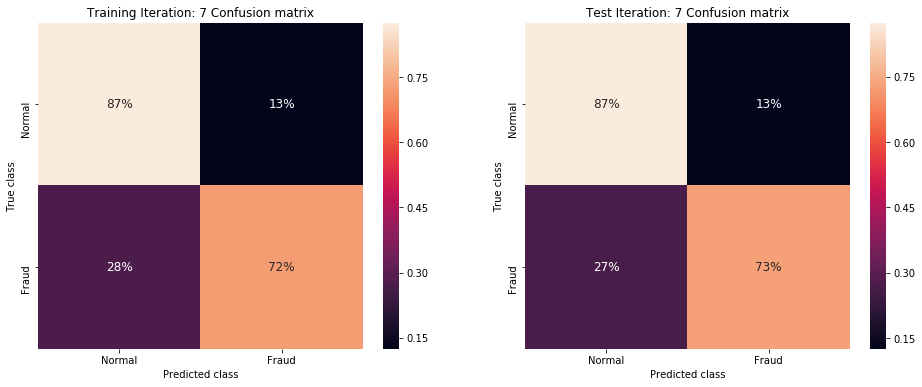

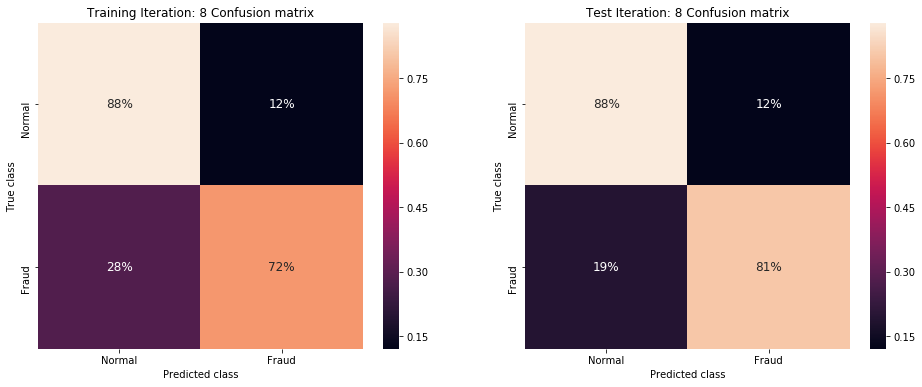

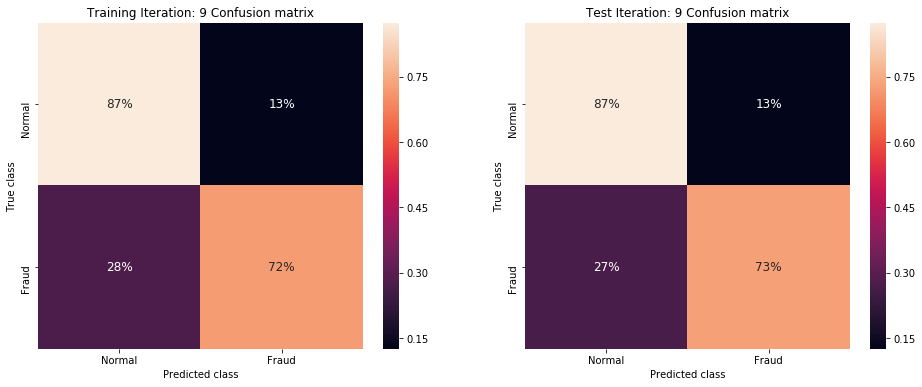

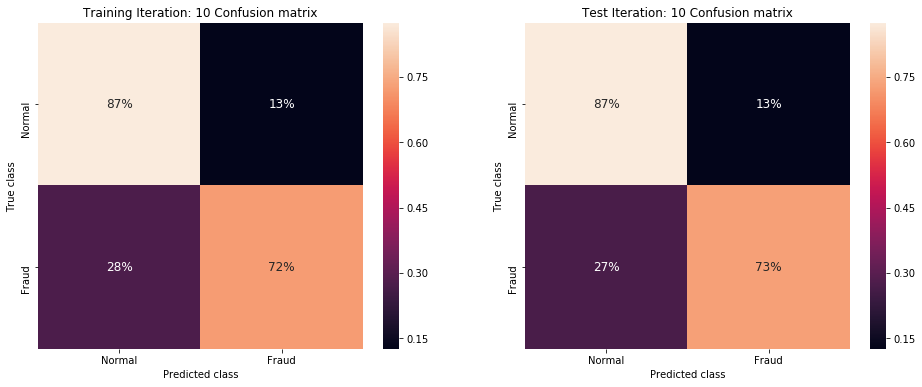

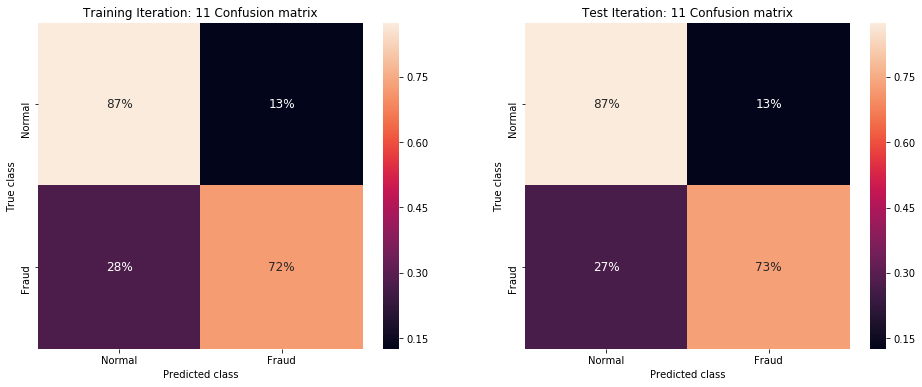

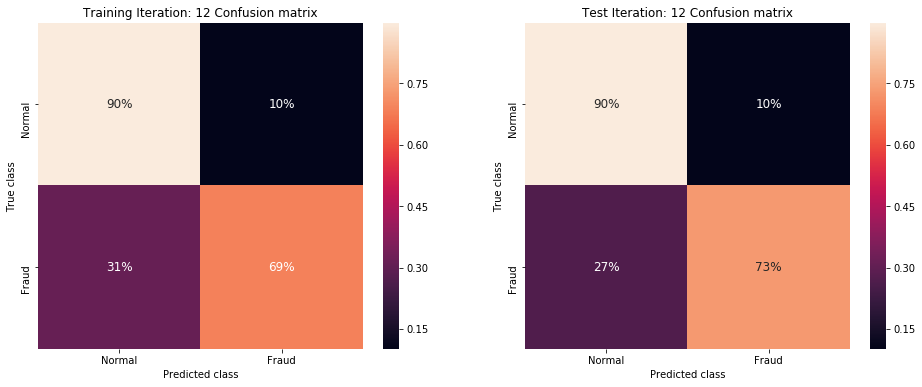

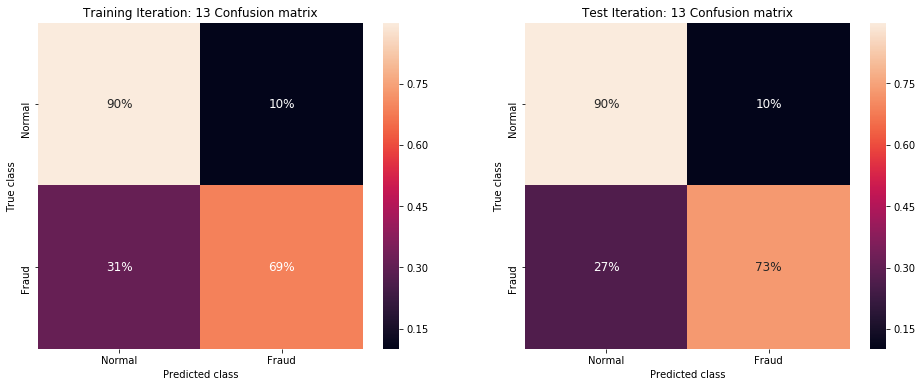

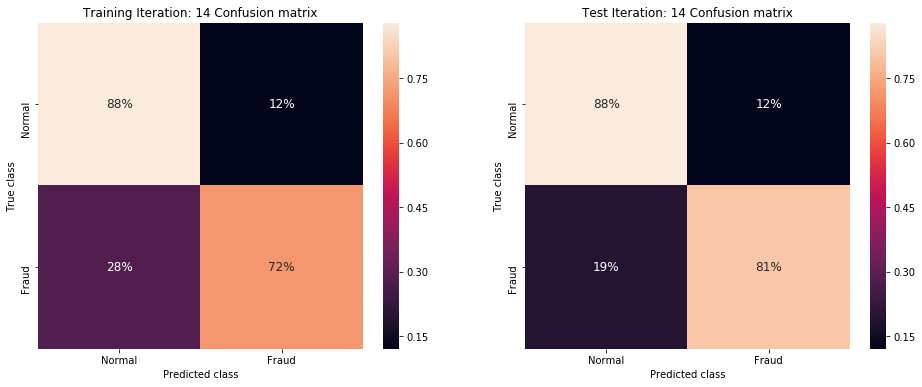

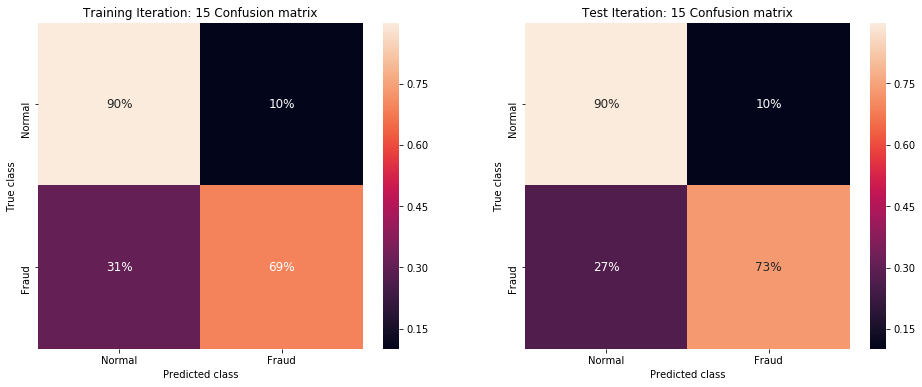

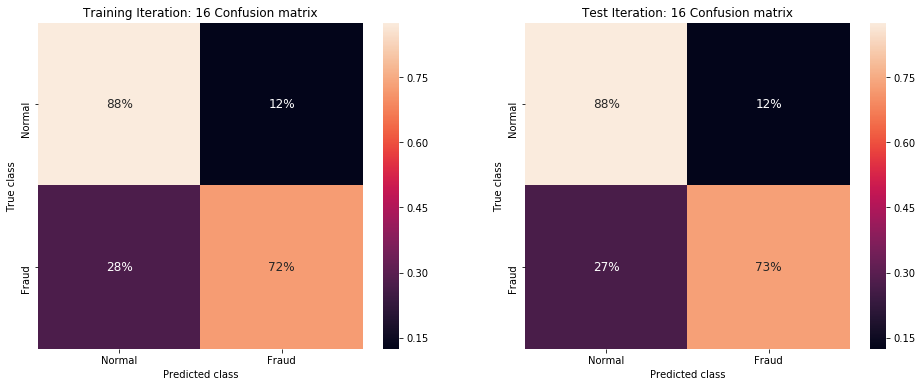

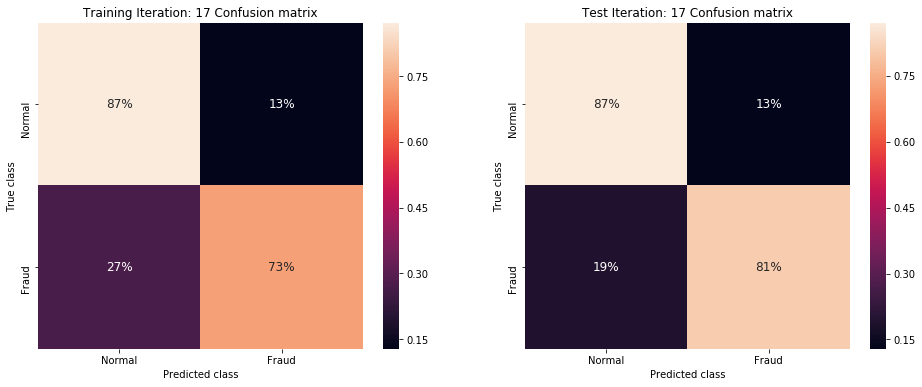

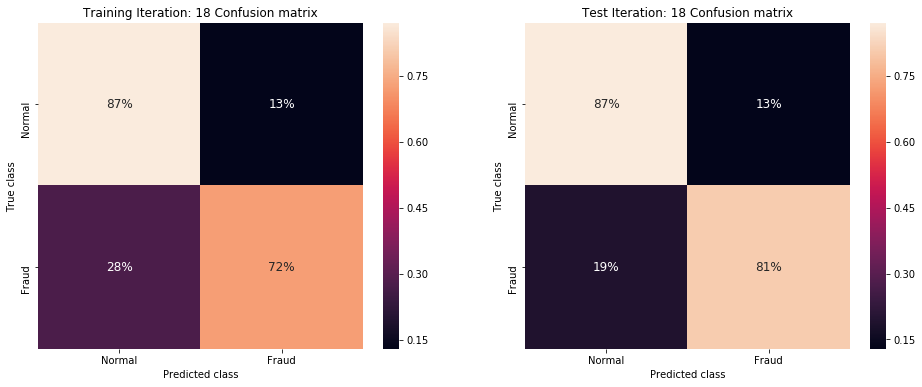

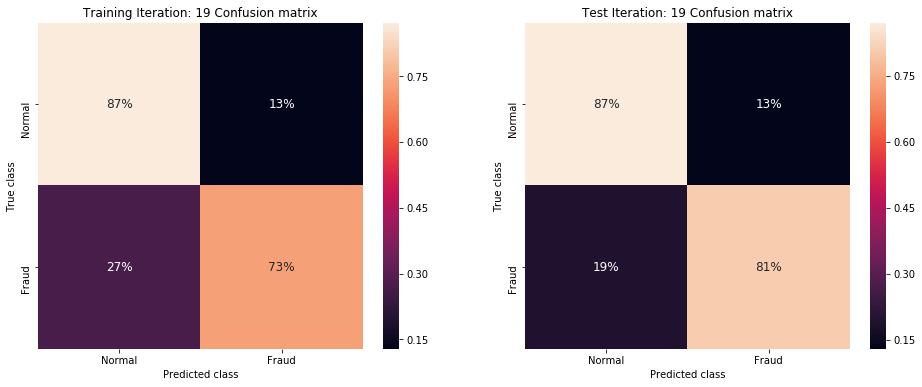

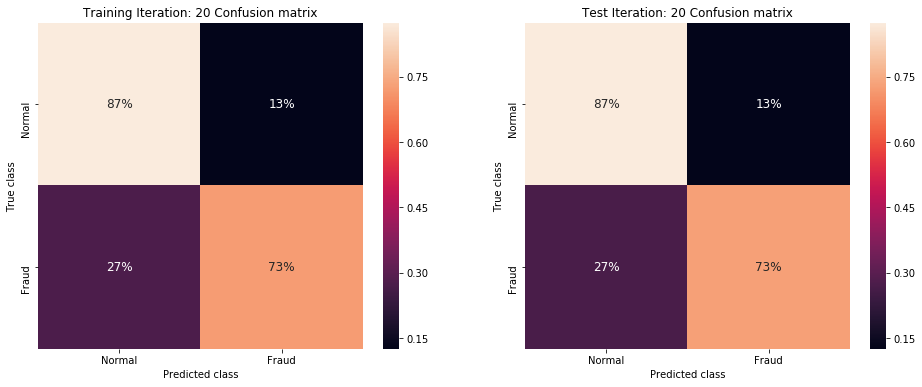

In [33]:
for it in iterations:
    cnf_mtx_train = training_evaluations[it]['conf_matrix']
    cnf_mtx_test = test_evaluations[it]['conf_matrix']
    conf_matrix_percent(cnf_mtx_train, cnf_mtx_test, it)

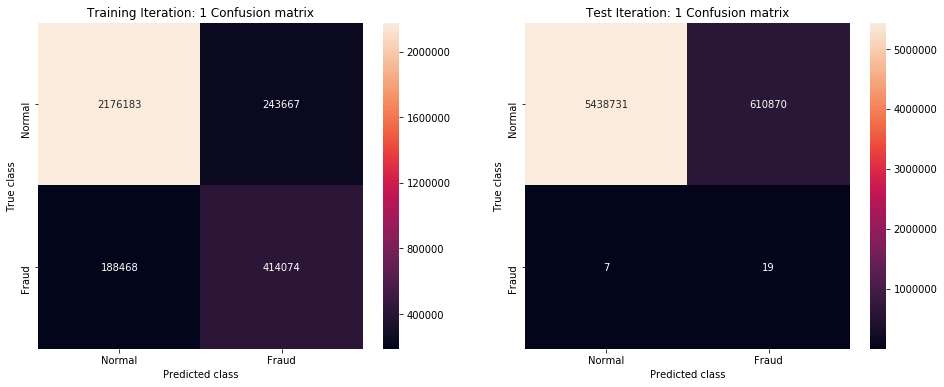

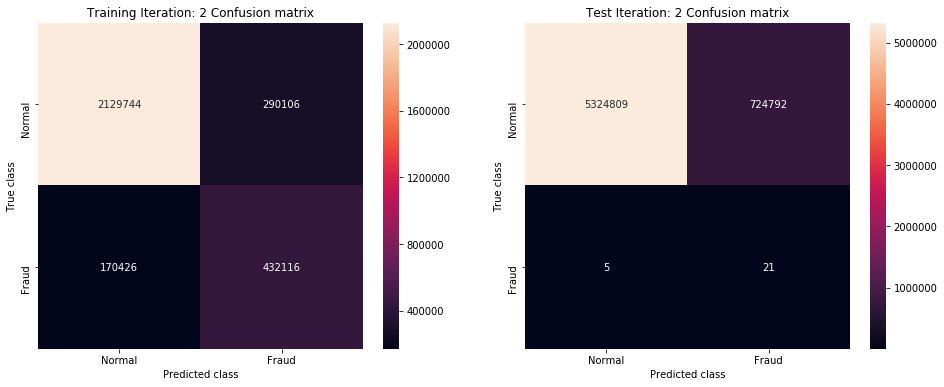

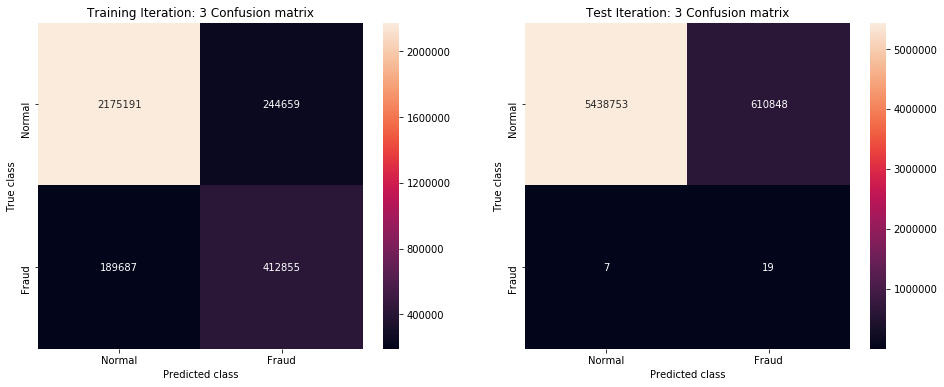

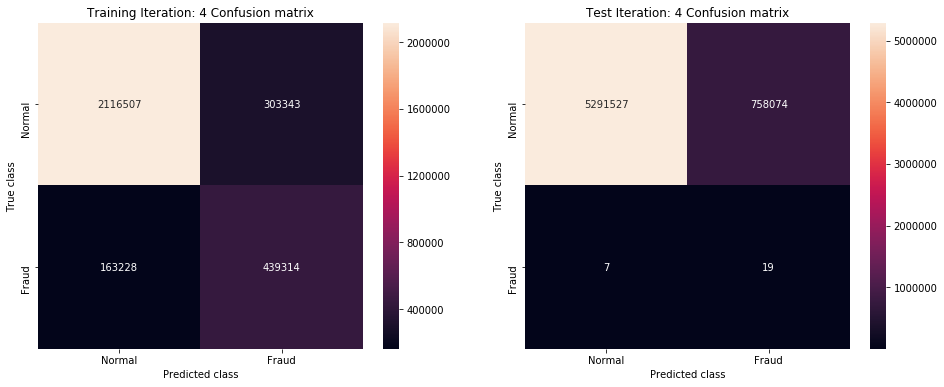

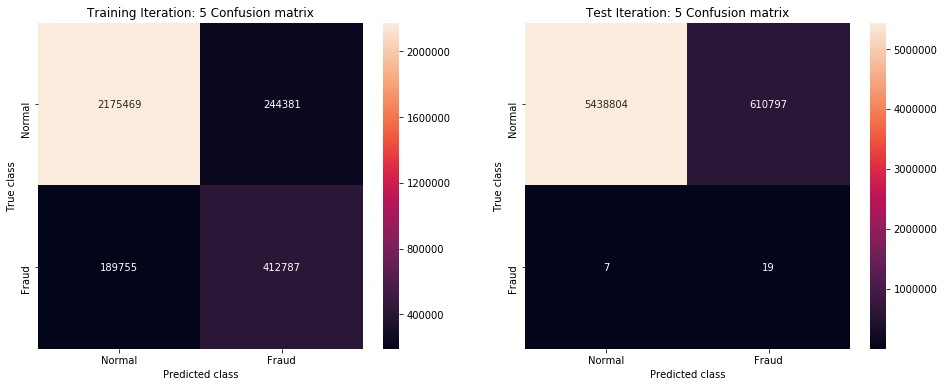

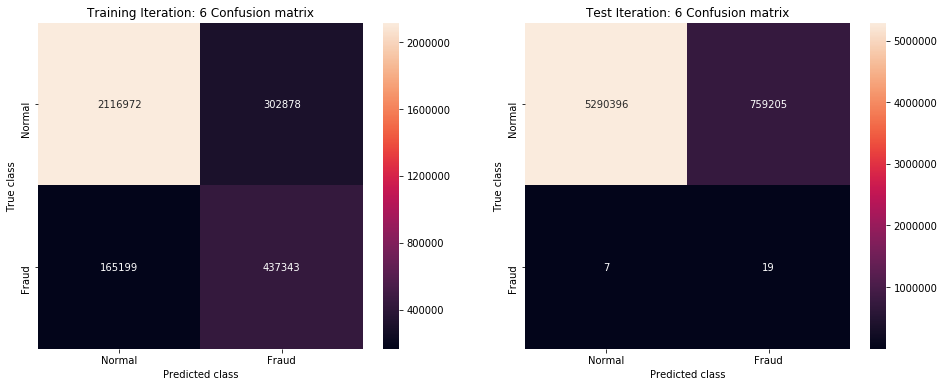

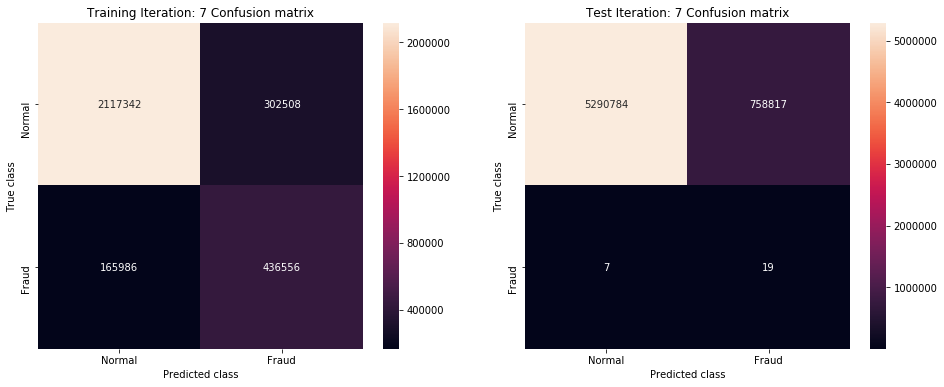

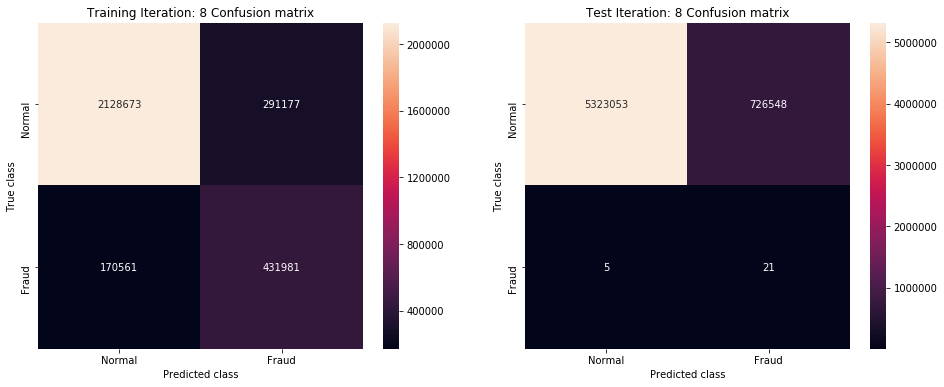

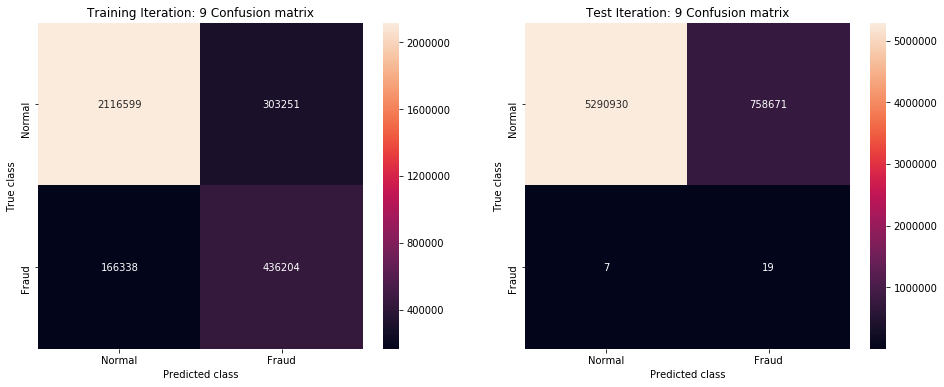

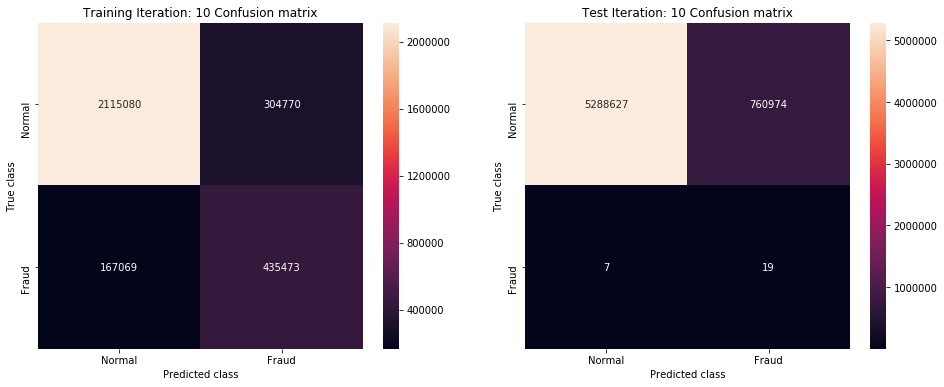

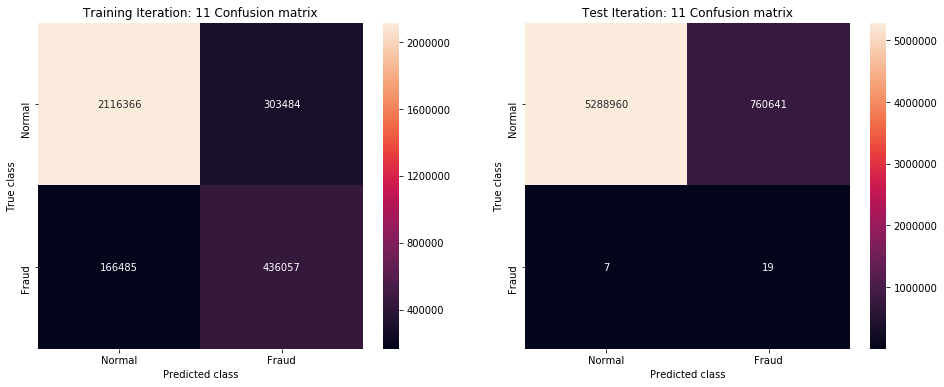

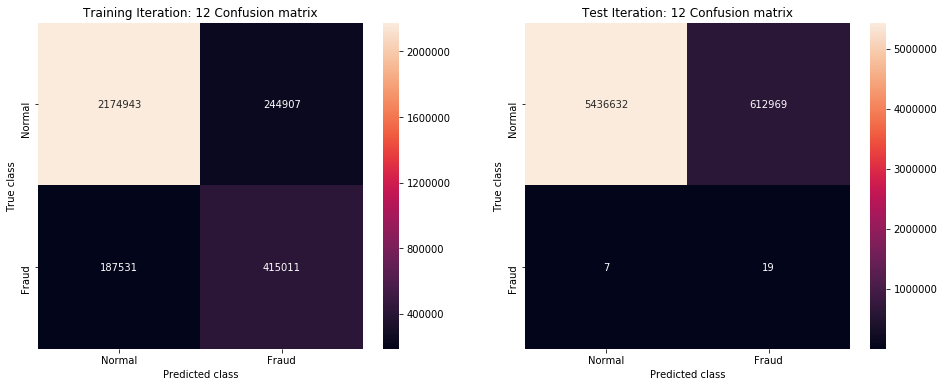

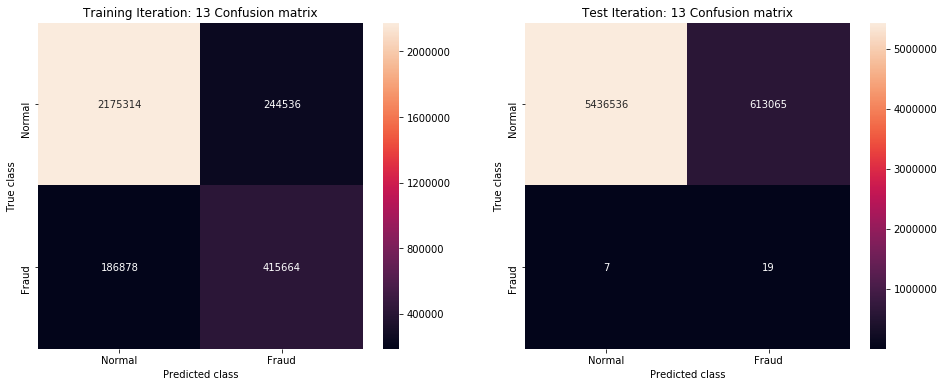

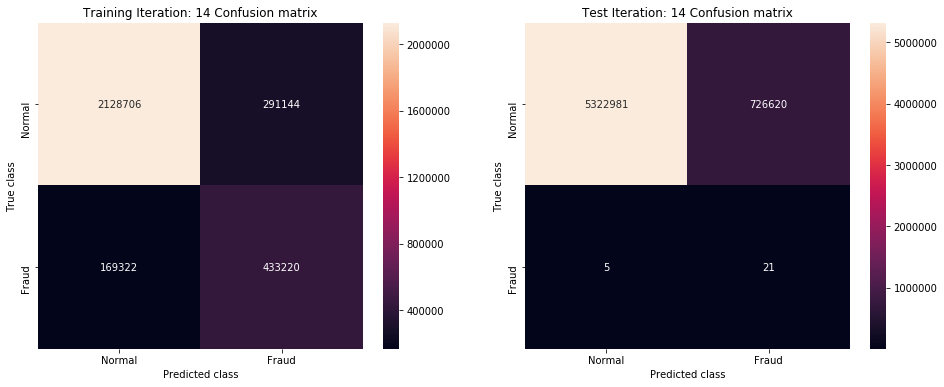

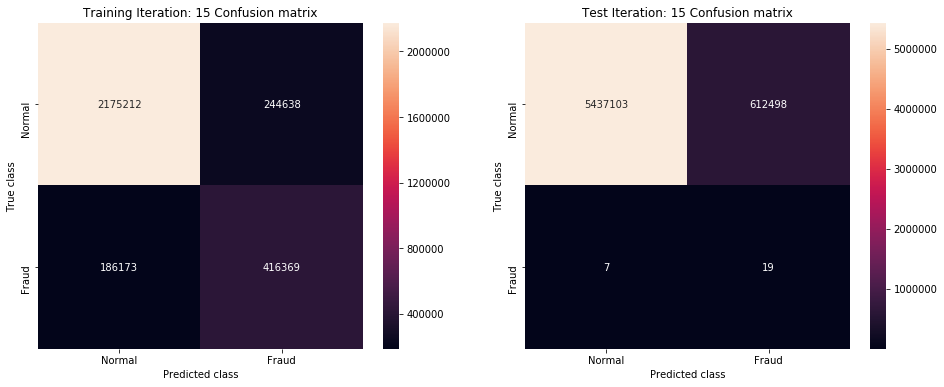

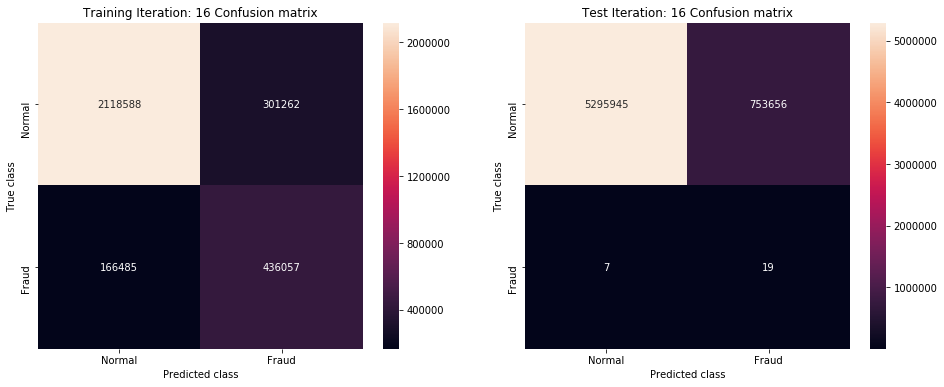

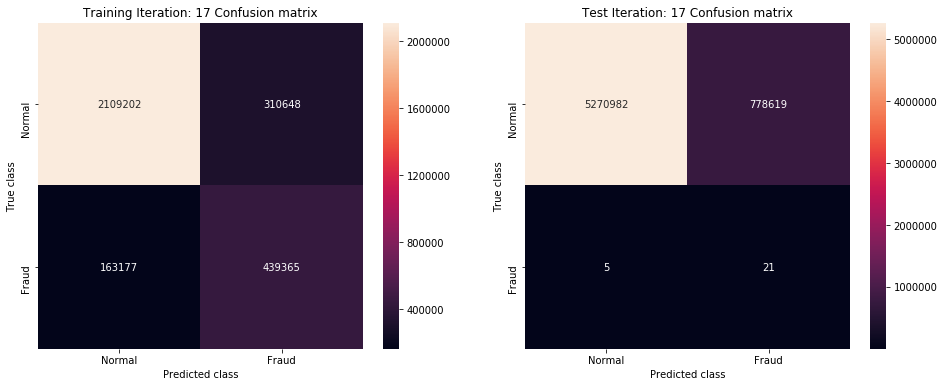

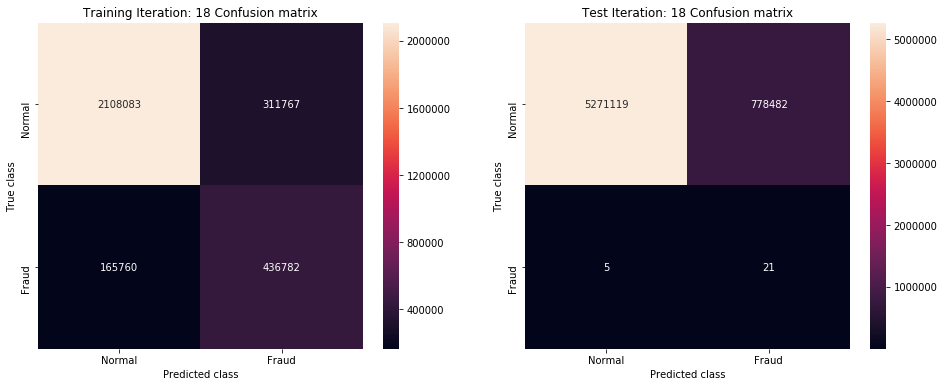

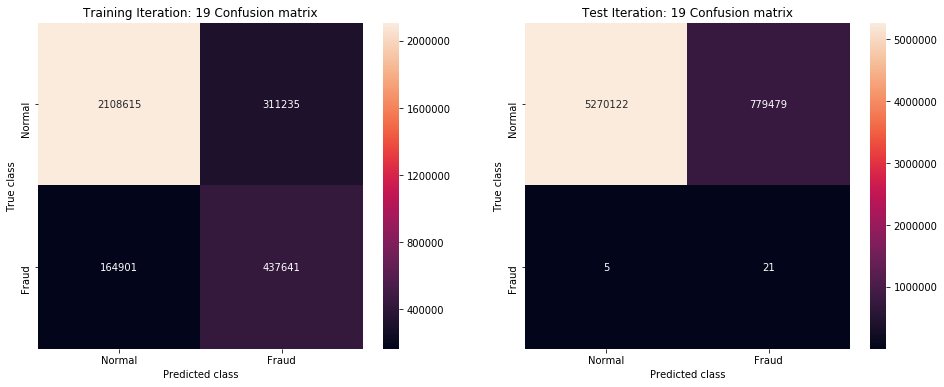

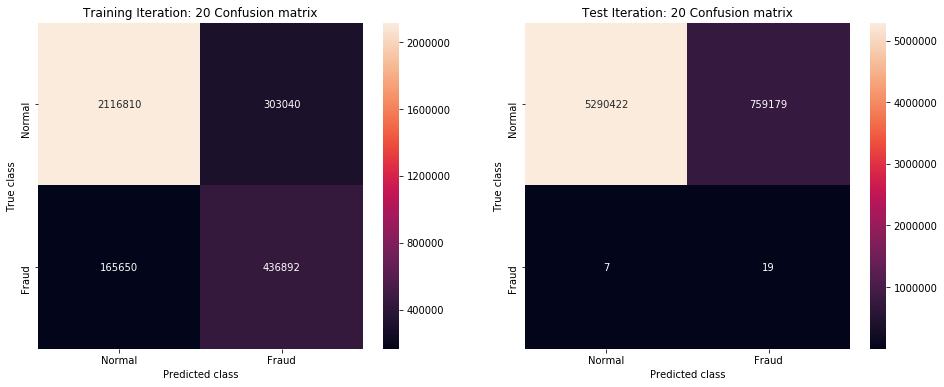

In [34]:
for it in iterations:
    cnf_mtx_train = training_evaluations[it]['conf_matrix']
    cnf_mtx_test = test_evaluations[it]['conf_matrix']
    conf_matrix_normal(cnf_mtx_train, cnf_mtx_test, it)

# Parameter Tuning

In [19]:
from hyperopt import Trials, STATUS_OK, fmin, tpe, hp

space={
'n_bins': hp.uniform('n_bins', 5, 110),
'outliers_fraction': hp.uniform('outliers_fraction', 0.05, 0.25),
'alpha': hp.uniform('alpha', 0.1, 0.9),
'tol': hp.uniform('tol', 0.1, 0.9)
}

random_state = 42
training_sample_size = int(len(original_ytrain) / 10)
sample_Xtrain, sample_ytrain = get_training_sample(training_sample_size)
print('Training With:')
print(pd.value_counts(sample_ytrain))


def hyper_parm_opt(space):
    start = time.time()
    n_bins = int(space['n_bins'])
    outliers_fraction = space['outliers_fraction']
    alpha = space['alpha']
    tol = space['tol']
    print(n_bins)
    X_train, y_train = oversample_minority_class(sample_Xtrain, sample_ytrain, outliers_fraction)
    clf = HBOS(n_bins=n_bins, alpha=alpha, tol=tol, contamination=outliers_fraction)
    clf.fit(X_train)
    y_train_pred = clf.labels_
    score = f1_score(y_train, y_train_pred, average="macro")
    val = 1 - score
    end = time.time()
    print('time: ' + str(round(end - start, 4)) + ' seconds')
    print('params: '+ str(space))
    print('val: ' + str(val))
    print('')
    return {'loss': val, 'status': STATUS_OK}


trials = Trials()
best = fmin(fn=hyper_parm_opt, space=space, algo=tpe.suggest, max_evals=500, trials=trials)


print('\n\n\nbest: {}'.format(best))

Training With:
0    2419850
1         82
dtype: int64
90
time: 8.3906 seconds
params: {'alpha': 0.3642034128514635, 'n_bins': 90.53008099023833, 'outliers_fraction': 0.227682933015524, 'tol': 0.7469533866638893}
val: 0.26981349341226535

71
time: 5.0918 seconds
params: {'alpha': 0.7516507416646522, 'n_bins': 71.53643382463004, 'outliers_fraction': 0.08751205817252164, 'tol': 0.7564503655679642}
val: 0.3090814154872985

42
time: 4.1918 seconds
params: {'alpha': 0.8249065808706375, 'n_bins': 42.92433748579436, 'outliers_fraction': 0.08060030151747598, 'tol': 0.20798836496779521}
val: 0.3189279523200732

106
time: 7.6291 seconds
params: {'alpha': 0.5234702366487627, 'n_bins': 106.28924972695948, 'outliers_fraction': 0.2447113123289094, 'tol': 0.20340900594070074}
val: 0.27741351714672113

18
time: 6.0935 seconds
params: {'alpha': 0.33911112358671486, 'n_bins': 18.111448889969125, 'outliers_fraction': 0.2282463594697659, 'tol': 0.35035843686234835}
val: 0.28265039347583487

49
time: 5.013 

time: 3.0804 seconds
params: {'alpha': 0.45746721024265957, 'n_bins': 9.870588736380158, 'outliers_fraction': 0.05008145557839905, 'tol': 0.28879407607332924}
val: 0.270618928374323

17
time: 6.0357 seconds
params: {'alpha': 0.7796213993600893, 'n_bins': 17.89138225612885, 'outliers_fraction': 0.22626801173223912, 'tol': 0.3626902264373285}
val: 0.28152681802492396

15
time: 4.8124 seconds
params: {'alpha': 0.6185243262778095, 'n_bins': 15.081718028480525, 'outliers_fraction': 0.14971990296528598, 'tol': 0.64466420306395}
val: 0.2762527962191843

5
time: 6.3609 seconds
params: {'alpha': 0.8989649803102716, 'n_bins': 5.225395126978878, 'outliers_fraction': 0.2364353703630169, 'tol': 0.7538964150983639}
val: 0.24049528610631277

33
time: 4.6081 seconds
params: {'alpha': 0.3125024827595792, 'n_bins': 33.47373893477947, 'outliers_fraction': 0.1385429819213988, 'tol': 0.2007087675638497}
val: 0.2703586948967418

39
time: 5.1568 seconds
params: {'alpha': 0.6654284069555325, 'n_bins': 39.8303

time: 5.7633 seconds
params: {'alpha': 0.8240008172165031, 'n_bins': 5.225646180545697, 'outliers_fraction': 0.2225222067257309, 'tol': 0.338341601644031}
val: 0.24077059254590194

33
time: 5.1411 seconds
params: {'alpha': 0.7580075202888853, 'n_bins': 33.611235811121915, 'outliers_fraction': 0.18812049686240012, 'tol': 0.4722511909977004}
val: 0.27572096465081763

30
time: 5.7116 seconds
params: {'alpha': 0.678438269323647, 'n_bins': 30.23564132145929, 'outliers_fraction': 0.2020536443847729, 'tol': 0.1907637910895993}
val: 0.2796731971364914

52
time: 4.5901 seconds
params: {'alpha': 0.6107610534226975, 'n_bins': 52.612720360462944, 'outliers_fraction': 0.15133573032879882, 'tol': 0.537769345272874}
val: 0.29431921221910695

22
time: 3.8674 seconds
params: {'alpha': 0.5400407059222981, 'n_bins': 22.766783613780092, 'outliers_fraction': 0.11262954314942539, 'tol': 0.7846091162774117}
val: 0.29628984337462017

68
time: 5.9893 seconds
params: {'alpha': 0.7250068970733611, 'n_bins': 68.4

time: 6.8468 seconds
params: {'alpha': 0.5141905828435877, 'n_bins': 55.43594970241369, 'outliers_fraction': 0.2220286919218012, 'tol': 0.7405858510806855}
val: 0.276782160963689

24
time: 6.6316 seconds
params: {'alpha': 0.5507602078698423, 'n_bins': 24.585016847574714, 'outliers_fraction': 0.24518507044298915, 'tol': 0.543919458332889}
val: 0.2821639716583906

89
time: 5.8591 seconds
params: {'alpha': 0.830154890059517, 'n_bins': 89.04528828368582, 'outliers_fraction': 0.2126874957085397, 'tol': 0.354596710487715}
val: 0.29394636445397015

68
time: 3.3788 seconds
params: {'alpha': 0.5920004952195402, 'n_bins': 68.43003424546367, 'outliers_fraction': 0.05606914588061032, 'tol': 0.48614589282462994}
val: 0.3143611477888988

17
time: 5.6862 seconds
params: {'alpha': 0.8046540348732967, 'n_bins': 17.923127175331338, 'outliers_fraction': 0.19951126198283659, 'tol': 0.4257357341113228}
val: 0.29132437728113714

41
time: 7.2296 seconds
params: {'alpha': 0.4207993351697471, 'n_bins': 41.8354

time: 4.8488 seconds
params: {'alpha': 0.33395380759910737, 'n_bins': 39.23358195555323, 'outliers_fraction': 0.1689575126013622, 'tol': 0.6748470479384409}
val: 0.26518426678327667

14
time: 6.6458 seconds
params: {'alpha': 0.4694325121215992, 'n_bins': 14.77292531290961, 'outliers_fraction': 0.24084645977950406, 'tol': 0.6522096173031132}
val: 0.28229130256170465

7
time: 6.188 seconds
params: {'alpha': 0.1468133665886467, 'n_bins': 7.764788534531083, 'outliers_fraction': 0.22492356263657123, 'tol': 0.7059629182040377}
val: 0.2131008494277089

19
time: 6.0333 seconds
params: {'alpha': 0.147242209576562, 'n_bins': 19.28404835222199, 'outliers_fraction': 0.24707156010836193, 'tol': 0.609870406393126}
val: 0.2773880923694809

95
time: 5.9857 seconds
params: {'alpha': 0.18160665902788964, 'n_bins': 95.24740883313498, 'outliers_fraction': 0.22775470298022488, 'tol': 0.7015202402787031}
val: 0.27041210377401004

32
time: 5.7685 seconds
params: {'alpha': 0.11747659083814282, 'n_bins': 32.25

time: 4.7949 seconds
params: {'alpha': 0.2562954154811287, 'n_bins': 13.11447288292569, 'outliers_fraction': 0.16560306962556237, 'tol': 0.6655639546123426}
val: 0.2689583116181966

28
time: 5.3578 seconds
params: {'alpha': 0.7616846103006899, 'n_bins': 28.231768217634116, 'outliers_fraction': 0.19212135276163655, 'tol': 0.8400525853781914}
val: 0.2848852984135509

24
time: 6.1418 seconds
params: {'alpha': 0.89985760442035, 'n_bins': 24.57333052520255, 'outliers_fraction': 0.24682369785885147, 'tol': 0.867810023939221}
val: 0.28483497452507844

18
time: 4.6214 seconds
params: {'alpha': 0.341409536515891, 'n_bins': 18.737533850744455, 'outliers_fraction': 0.15963271134722196, 'tol': 0.6064851528165072}
val: 0.2880631096006061

10
time: 5.5914 seconds
params: {'alpha': 0.6785895873291534, 'n_bins': 10.025107861528088, 'outliers_fraction': 0.22090408743156517, 'tol': 0.6862609624134357}
val: 0.2404763579228677

16
time: 6.0406 seconds
params: {'alpha': 0.28364636476531924, 'n_bins': 16.03

time: 5.4115 seconds
params: {'alpha': 0.5331945913933597, 'n_bins': 5.180763756112814, 'outliers_fraction': 0.22981093326685903, 'tol': 0.4166691253035515}
val: 0.23820498475199647

22
time: 5.6792 seconds
params: {'alpha': 0.6350677165611874, 'n_bins': 22.107130019177667, 'outliers_fraction': 0.239028863557068, 'tol': 0.4247191713005227}
val: 0.28204118713739756

18
time: 5.9049 seconds
params: {'alpha': 0.5706058856029866, 'n_bins': 18.57304654229373, 'outliers_fraction': 0.2493216824706583, 'tol': 0.4654479381861037}
val: 0.2886703589863713

11
time: 5.3781 seconds
params: {'alpha': 0.607842916867145, 'n_bins': 11.161248975140932, 'outliers_fraction': 0.2197907885932103, 'tol': 0.5560961141006315}
val: 0.228026997952254

6
time: 5.7889 seconds
params: {'alpha': 0.45909145743793794, 'n_bins': 6.537996397519115, 'outliers_fraction': 0.2495084220103216, 'tol': 0.4004391540583084}
val: 0.20895917710743328

24
time: 5.9058 seconds
params: {'alpha': 0.46187754703939427, 'n_bins': 24.7808

time: 5.758 seconds
params: {'alpha': 0.583562219739476, 'n_bins': 8.968817769946424, 'outliers_fraction': 0.2455877251221112, 'tol': 0.3927567537744146}
val: 0.22702803793217785

19
time: 5.8541 seconds
params: {'alpha': 0.4836984198332448, 'n_bins': 19.564977930608606, 'outliers_fraction': 0.22829225397436037, 'tol': 0.5173505087103557}
val: 0.28253437306385765

23
time: 6.2406 seconds
params: {'alpha': 0.41558990523214173, 'n_bins': 23.439497279654546, 'outliers_fraction': 0.23864268565396388, 'tol': 0.4592619545293375}
val: 0.28236396584781176

52
time: 4.7836 seconds
params: {'alpha': 0.6902471656704894, 'n_bins': 52.973927979370565, 'outliers_fraction': 0.14498623178187167, 'tol': 0.3247436027050798}
val: 0.30200879759436816

28
time: 5.6987 seconds
params: {'alpha': 0.6579762199052785, 'n_bins': 28.191169875929823, 'outliers_fraction': 0.23174277902802762, 'tol': 0.3454167884939038}
val: 0.2770728609550679

5
time: 5.1712 seconds
params: {'alpha': 0.4324897754801048, 'n_bins': 5

time: 3.5538 seconds
params: {'alpha': 0.5386303995154764, 'n_bins': 7.505129232855975, 'outliers_fraction': 0.08934296530206665, 'tol': 0.464820295382983}
val: 0.2605349838583322

15
time: 5.6683 seconds
params: {'alpha': 0.5181964919469477, 'n_bins': 15.807472744410573, 'outliers_fraction': 0.20978699540732326, 'tol': 0.4869392819148635}
val: 0.26413718647121653

84
time: 6.4266 seconds
params: {'alpha': 0.37851155274234094, 'n_bins': 84.20601612413064, 'outliers_fraction': 0.24757398493314398, 'tol': 0.35921218543870487}
val: 0.27317146383272917

91
time: 5.8885 seconds
params: {'alpha': 0.4423301658215839, 'n_bins': 91.67812594148322, 'outliers_fraction': 0.23459732891312524, 'tol': 0.2930449630397917}
val: 0.27422071440695195

8
time: 3.033 seconds
params: {'alpha': 0.6460157236122129, 'n_bins': 8.344272940638216, 'outliers_fraction': 0.06018790287794733, 'tol': 0.42050253928443615}
val: 0.27875858974367174

18
time: 6.6452 seconds
params: {'alpha': 0.4098799911614179, 'n_bins': 1

time: 5.4892 seconds
params: {'alpha': 0.6569312149841249, 'n_bins': 11.192173610674011, 'outliers_fraction': 0.22924619796513956, 'tol': 0.31550466529838167}
val: 0.22868075786658482

7
time: 5.3968 seconds
params: {'alpha': 0.7561593985774518, 'n_bins': 7.389026974192022, 'outliers_fraction': 0.22403282344482667, 'tol': 0.34027358118247664}
val: 0.21436939004797462

17
time: 6.2721 seconds
params: {'alpha': 0.7839543290839293, 'n_bins': 17.904751189752922, 'outliers_fraction': 0.24383040572595557, 'tol': 0.3613969945261662}
val: 0.2840238624982201

12
time: 5.7436 seconds
params: {'alpha': 0.8104578023950089, 'n_bins': 12.28994604236204, 'outliers_fraction': 0.23426583006397117, 'tol': 0.40925203170697594}
val: 0.22689357542497612

5
time: 5.7323 seconds
params: {'alpha': 0.7364239977224106, 'n_bins': 5.047709669935019, 'outliers_fraction': 0.2459434184913103, 'tol': 0.45802576528128014}
val: 0.24025365778568553

8
time: 5.7734 seconds
params: {'alpha': 0.6708756553029748, 'n_bins': 

time: 5.8211 seconds
params: {'alpha': 0.6870231565019361, 'n_bins': 15.086375065775137, 'outliers_fraction': 0.24977852936756947, 'tol': 0.6034035453371386}
val: 0.23029912667676866

29
time: 5.7705 seconds
params: {'alpha': 0.5617806645448644, 'n_bins': 29.607814774368418, 'outliers_fraction': 0.24009204718625637, 'tol': 0.5701911535287737}
val: 0.2802811053991421

11
time: 3.3045 seconds
params: {'alpha': 0.533130747995356, 'n_bins': 11.359133922482467, 'outliers_fraction': 0.08534691837353561, 'tol': 0.5014133933234907}
val: 0.27689412818313286

18
time: 5.8449 seconds
params: {'alpha': 0.486235361250484, 'n_bins': 18.299804799366633, 'outliers_fraction': 0.2496480948975295, 'tol': 0.6154766051336492}
val: 0.2879287462493304

8
time: 5.6592 seconds
params: {'alpha': 0.4626859797179991, 'n_bins': 8.542885938464721, 'outliers_fraction': 0.24712633627294048, 'tol': 0.5456755565562514}
val: 0.226503803165657

5
time: 4.2983 seconds
params: {'alpha': 0.41247078984071844, 'n_bins': 5.000

time: 5.8623 seconds
params: {'alpha': 0.5609184761516146, 'n_bins': 17.49755099107331, 'outliers_fraction': 0.24976224048084458, 'tol': 0.6090739635384821}
val: 0.2869863694472323

13
time: 5.9615 seconds
params: {'alpha': 0.5952765482991867, 'n_bins': 13.612238567802041, 'outliers_fraction': 0.23646409294720133, 'tol': 0.1979296887913028}
val: 0.2643474121956856

34
time: 5.8791 seconds
params: {'alpha': 0.6437789465115489, 'n_bins': 34.89411162018411, 'outliers_fraction': 0.22429625734338596, 'tol': 0.579337975398793}
val: 0.2821247803218512

11
time: 6.0753 seconds
params: {'alpha': 0.7994922414664486, 'n_bins': 11.118367197432702, 'outliers_fraction': 0.24149820629629298, 'tol': 0.44347848403155815}
val: 0.22592471033731543

22
time: 6.2146 seconds
params: {'alpha': 0.840725674474715, 'n_bins': 22.08176556779392, 'outliers_fraction': 0.24986464395005958, 'tol': 0.660741703282802}
val: 0.28890597152678654

8
time: 6.0521 seconds
params: {'alpha': 0.7005916642616583, 'n_bins': 8.413